In [ ]:
#All import statements
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import countDistinct
import pandas as pd
import plotly.express as px
from pyspark.sql.functions import year, month, count
from pyspark.sql.window import Window
from pyspark.sql.functions import to_date
from pyspark.sql.functions import col, to_date, year, month
import plotly.graph_objs as go



In [ ]:
spark = SparkSession.builder.appName("DataExtraction").getOrCreate()


In [ ]:

# Path to the folder containing CSV files
path_to_csv_folder = "/content/drive/MyDrive/reddit-data/*"

# Read all CSV files in the folder into a DataFrame
df = spark.read.option("multiline", "true").option("quote", '"').option("header", "true").option("inferSchema", "true").option("sep", ",").option("escape", "\"").csv(path_to_csv_folder)

df.show()

+----------+-------------------+----------+--------------------+---------------------------+------------------+--------------------------+-------------------+------------------+------------------+------------------+------------------+---------------------+-------+------------+--------------------+--------------------+-------+-----------+--------------+-------+--------------------+-------------------+-------------------+-------------+---------------------+---------------+-------------------+----------+---------------------+-----------------+-----------+-------------+-------------+-------------+----------------+------------+------------------------+----------+------------+---------------------+-----------+--------------------+---------------+---------+--------------+--------------+--------------+-----------------+-----------------+----------+----------------+--------------+-----------+---------+------------+------------+-----------------+-----------+---------+---------+-----------+------

In [ ]:
#Load Data
#Omitting all the feature columns because it was not extracted using my custom functions
selected_df = df.select("subreddit", "author", "date", "post").cache()

selected_df.show()

+----------+-------------------+----------+--------------------+
| subreddit|             author|      date|                post|
+----------+-------------------+----------+--------------------+
|depression|           peeepeed|2020/01/01|My heart aches bu...|
|depression|   cookieexpertuser|2020/01/01|Cheers I’m not su...|
|depression|         Ghostiez23|2020/01/01|Fuck titles. I’m ...|
|depression|           wisqrg50|2020/01/01|suffering from lo...|
|depression|   arizonwatermelon|2020/01/01|I can already tel...|
|depression|ThatBloodyValentine|2020/01/01|I just turned 19 ...|
|depression|     chiefkeith7511|2020/01/01|Is there any way ...|
|depression|        dustin_keel|2020/01/01|Horrid mood swing...|
|depression|         BaIA102037|2020/01/01|ANHEDONIA &amp; e...|
|depression|      bounce-bounce|2020/01/01|Empty I wanted to...|
|depression|    DrowningPilot21|2020/01/01|I'm still here Ca...|
|depression|      emogirl123456|2020/01/01|numb i’m thinking...|
|depression|          cut

In [ ]:
#Omit the ED/Anonymous subreddit because it does not span the timeframe that other subreddits do
remove_ED_filtered_df = selected_df.filter(col("subreddit") != "EDAnonymous").cache()


In [ ]:
#Now write each question, what transformation you need and save the resultant dataframe
#1. How many posts per subbreddit - group posts by subbreddit and count
subreddit_counts = remove_ED_filtered_df.groupBy('subreddit').count().orderBy('count', ascending=False)


In [ ]:
subreddit_counts.show()

+-------------+------+
|    subreddit| count|
+-------------+------+
|   depression|117331|
| suicidewatch| 66161|
|      anxiety| 57671|
|         adhd| 45631|
| mentalhealth| 45332|
|          bpd| 24294|
|       lonely| 23635|
|socialanxiety| 22996|
|       autism|  8869|
|schizophrenia|  8712|
|healthanxiety|  8648|
|         ptsd|  8643|
|    addiction|  7641|
|   alcoholism|  5911|
|bipolarreddit|  5780|
+-------------+------+



In [ ]:
from pyspark.sql.functions import col, year, month, count, concat_ws, date_format,desc


In [ ]:
#removing the month_year column created to try another approach
#remove_ED_filtered_df = remove_ED_filtered_df.drop("month_year")


In [ ]:
#unique month years
remove_ED_filtered_df = remove_ED_filtered_df.withColumn("date", to_date(col("date"), "yyyy/MM/dd"))


In [ ]:
remove_ED_filtered_df = remove_ED_filtered_df.withColumn("month_year", date_format(col("date"), "yyyy-MM")).cache()


In [ ]:
remove_ED_filtered_df = remove_ED_filtered_df.show()

+----------+-------------------+----------+--------------------+----------+
| subreddit|             author|      date|                post|month_year|
+----------+-------------------+----------+--------------------+----------+
|depression|           peeepeed|2020-01-01|My heart aches bu...|   2020-01|
|depression|   cookieexpertuser|2020-01-01|Cheers I’m not su...|   2020-01|
|depression|         Ghostiez23|2020-01-01|Fuck titles. I’m ...|   2020-01|
|depression|           wisqrg50|2020-01-01|suffering from lo...|   2020-01|
|depression|   arizonwatermelon|2020-01-01|I can already tel...|   2020-01|
|depression|ThatBloodyValentine|2020-01-01|I just turned 19 ...|   2020-01|
|depression|     chiefkeith7511|2020-01-01|Is there any way ...|   2020-01|
|depression|        dustin_keel|2020-01-01|Horrid mood swing...|   2020-01|
|depression|         BaIA102037|2020-01-01|ANHEDONIA &amp; e...|   2020-01|
|depression|      bounce-bounce|2020-01-01|Empty I wanted to...|   2020-01|
|depression|

In [ ]:
posts_per_month_year_df = remove_ED_filtered_df.groupBy("month_year").agg(count("post").alias("num_posts"))


In [ ]:
sorted_df = posts_per_month_year_df.orderBy(desc("month_year"))

In [ ]:
sorted_df.show(sorted_df.count(), truncate=False)


+----------+---------+
|month_year|num_posts|
+----------+---------+
|2020-04   |19749    |
|2020-03   |33197    |
|2020-02   |36621    |
|2020-01   |43691    |
|2019-11   |574      |
|2019-10   |17333    |
|2019-09   |15000    |
|2019-08   |15707    |
|2019-07   |16328    |
|2019-06   |11531    |
|2019-05   |11856    |
|2019-04   |29934    |
|2019-03   |41005    |
|2019-02   |36541    |
|2019-01   |42241    |
|2018-12   |11090    |
|2018-11   |11647    |
|2018-04   |11786    |
|2018-03   |16204    |
|2018-02   |15931    |
|2018-01   |19289    |
+----------+---------+



In [ ]:
#Remove posts from Nov- Dec 2018, May - Dec 2019, to keep the timeframe even across the three years
timeframe_filtered_df = remove_ED_filtered_df.filter(
    ((col("month_year") >= "2018-01") & (col("month_year") <= "2018-04")) |
    ((col("month_year") >= "2019-01") & (col("month_year") <= "2019-04")) |
    ((col("month_year") >= "2020-01") & (col("month_year") <= "2020-04"))
)

In [ ]:
timeframe_filtered_df.show()

+----------+-------------------+----------+--------------------+----------+
| subreddit|             author|      date|                post|month_year|
+----------+-------------------+----------+--------------------+----------+
|depression|           peeepeed|2020-01-01|My heart aches bu...|   2020-01|
|depression|   cookieexpertuser|2020-01-01|Cheers I’m not su...|   2020-01|
|depression|         Ghostiez23|2020-01-01|Fuck titles. I’m ...|   2020-01|
|depression|           wisqrg50|2020-01-01|suffering from lo...|   2020-01|
|depression|   arizonwatermelon|2020-01-01|I can already tel...|   2020-01|
|depression|ThatBloodyValentine|2020-01-01|I just turned 19 ...|   2020-01|
|depression|     chiefkeith7511|2020-01-01|Is there any way ...|   2020-01|
|depression|        dustin_keel|2020-01-01|Horrid mood swing...|   2020-01|
|depression|         BaIA102037|2020-01-01|ANHEDONIA &amp; e...|   2020-01|
|depression|      bounce-bounce|2020-01-01|Empty I wanted to...|   2020-01|
|depression|

In [ ]:
posts_count_df = timeframe_filtered_df.groupBy("month_year").agg(count("post").alias("num_posts"))
posts_count_df = posts_count_df.orderBy("month_year")

In [ ]:
#now grpup by month_year and get count per month and visualize
posts_count_df = timeframe_filtered_df.groupBy("month_year").agg(count("post").alias("num_posts"))
posts_count_df = posts_count_df.orderBy("month_year")
pandas_df = posts_count_df.toPandas()
pandas_df['month_year'] = pd.Categorical(pandas_df['month_year'], ordered=True)

# Create the bar chart
fig = px.bar(pandas_df, x='month_year', y='num_posts',

fig.show()

In [ ]:
posts_count_df.show()

In [ ]:
'''from this we see that the timeframe_filtered df has been filtered properly'''

'from this we see that the timeframe_filtered df has been filtered properly'

In [ ]:
monthly_post_counts = (
    timeframe_filtered_df
    .groupBy(year("date").alias("year"), month("date").alias("month"))
    .agg(count("post").alias("num_posts"))
    .orderBy("year", "month")
)

monthly_post_counts.show()

+----+-----+---------+
|year|month|num_posts|
+----+-----+---------+
|2018|    1|    19289|
|2018|    2|    15931|
|2018|    3|    16204|
|2018|    4|    11786|
|2019|    1|    42241|
|2019|    2|    36541|
|2019|    3|    41005|
|2019|    4|    29934|
|2020|    1|    43691|
|2020|    2|    36621|
|2020|    3|    33197|
|2020|    4|    19749|
+----+-----+---------+



In [ ]:
from pyspark.sql import avg
timeframe_filtered_df = timeframe_filtered_df.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))
timeframe_filtered_df = timeframe_filtered_df.withColumn("month_year", date_format(col("date"), "yyyy-MM"))

# Count the number of posts per 'month_year'
posts_per_month_year_df = timeframe_filtered_df.groupBy("month_year").agg(count("post").alias("num_posts"))

# Filter for the pre-COVID timeframe and calculate the average number of posts
avg_posts_pre_covid = posts_per_month_year_df.filter(
    (col("month_year") >= "2018-01") & (col("month_year") < "2019-05")
).agg(avg("num_posts").alias("avg_pre_covid"))

# Filter for the COVID timeframe and calculate the average number of posts
avg_posts_covid = posts_per_month_year_df.filter(
    (col("month_year") >= "2020-01") & (col("month_year") <= "2020-04")
).agg(avg("num_posts").alias("avg_during_covid"))

# Show the results
avg_posts_pre_covid.show()
avg_posts_covid.show()

+-------------+
|avg_pre_covid|
+-------------+
|    26616.375|
+-------------+

+----------------+
|avg_during_covid|
+----------------+
|         33314.5|
+----------------+



In [ ]:
# Retrieve the average values from the DataFrames
avg_pre_covid_value = 26616.375
avg_during_covid_value = 33314.5
# Calculate the percentage of increase
percentage_increase = ((avg_during_covid_value - avg_pre_covid_value) / avg_pre_covid_value) * 100

# Print the percentage of increase
print(f"The percentage increase in average posts from pre-COVID to during COVID is: {percentage_increase}%")


The percentage increase in average posts from pre-COVID to during COVID is: 25.165429176587722%


In [ ]:
# Count the number of posts per subreddit and month_year
posts_count = (
    timeframe_filtered_df
    .groupBy("subreddit", "month_year")
    .agg(count("post").alias("num_posts"))
)

# Calculate the average number of posts per subreddit before COVID
avg_posts_pre_covid = (
    posts_count
    .filter((col("month_year") >= "2018-01") & (col("month_year") < "2019-05"))
    .groupBy("subreddit")
    .agg(avg("num_posts").alias("avg_pre_covid"))
)

# Calculate the average number of posts per subreddit during COVID
avg_posts_covid = (
    posts_count
    .filter((col("month_year") >= "2020-01") & (col("month_year") <= "2020-04"))
    .groupBy("subreddit")
    .agg(avg("num_posts").alias("avg_during_covid"))
)

# Join the two dataframes on 'subreddit'
combined_df = avg_posts_pre_covid.join(avg_posts_covid, "subreddit")

# Calculate the percentage increase for each subreddit
combined_df = combined_df.withColumn(
    "percentage_increase",
    ((col("avg_during_covid") - col("avg_pre_covid")) / col("avg_pre_covid")) * 100
)

# Show the results
combined_df.show()

+-------------+-------------+----------------+-------------------+
|    subreddit|avg_pre_covid|avg_during_covid|percentage_increase|
+-------------+-------------+----------------+-------------------+
|         adhd|       2675.5|          3400.5|  27.09773874042235|
|       autism|        428.5|          552.25| 28.879813302217038|
| mentalhealth|     2333.875|          3378.5|  44.75925231642655|
|          bpd|     1373.625|         1493.25|  8.708708708708707|
|    addiction|      379.875|          445.75|  17.34123066798289|
|   depression|     8100.875|         9508.25|  17.37312327372043|
|socialanxiety|     1366.625|           934.5| -31.61986645934327|
|bipolarreddit|       309.75|           342.0| 10.411622276029057|
| suicidewatch|      3841.75|          5352.5| 39.324526582937466|
|         ptsd|      426.625|          514.75|  20.65631409317316|
|   alcoholism|        298.5|           357.0| 19.597989949748744|
|       lonely|      860.875|         1988.75| 131.01495571366

In [ ]:
#Calculating correlation coefficeint between no of posts and no of covid deaths
#load the covid dataset
path_to_covid_19 ="/content/drive/MyDrive/us.csv"
covid_deaths = spark.read.option("multiline", "true").option("quote", '"').option("header", "true").option("inferSchema", "true").option("sep", ",").option("escape", "\"").csv(path_to_covid_19)



In [ ]:
covid_deaths.show()

+----------+-----+------+
|      date|cases|deaths|
+----------+-----+------+
|2020-01-21|    1|     0|
|2020-01-22|    1|     0|
|2020-01-23|    1|     0|
|2020-01-24|    2|     0|
|2020-01-25|    3|     0|
|2020-01-26|    5|     0|
|2020-01-27|    5|     0|
|2020-01-28|    5|     0|
|2020-01-29|    5|     0|
|2020-01-30|    6|     0|
|2020-01-31|    7|     0|
|2020-02-01|    8|     0|
|2020-02-02|   11|     0|
|2020-02-03|   11|     0|
|2020-02-04|   11|     0|
|2020-02-05|   12|     0|
|2020-02-06|   12|     0|
|2020-02-07|   12|     0|
|2020-02-08|   12|     0|
|2020-02-09|   12|     0|
+----------+-----+------+
only showing top 20 rows



In [ ]:

# Assuming 'covid_df' is your DataFrame with the 'date', 'cases', and 'deaths' columns

# Convert 'date' to a date type if it's not already
covid_deaths = covid_deaths.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))

# Create 'month_year' column
covid_deaths = covid_deaths.withColumn("month_year", date_format(col("date"), "yyyy-MM"))

# Show the resulting DataFrame
covid_deaths.show()




+----------+-----+------+----------+
|      date|cases|deaths|month_year|
+----------+-----+------+----------+
|2020-01-21|    1|     0|   2020-01|
|2020-01-22|    1|     0|   2020-01|
|2020-01-23|    1|     0|   2020-01|
|2020-01-24|    2|     0|   2020-01|
|2020-01-25|    3|     0|   2020-01|
|2020-01-26|    5|     0|   2020-01|
|2020-01-27|    5|     0|   2020-01|
|2020-01-28|    5|     0|   2020-01|
|2020-01-29|    5|     0|   2020-01|
|2020-01-30|    6|     0|   2020-01|
|2020-01-31|    7|     0|   2020-01|
|2020-02-01|    8|     0|   2020-02|
|2020-02-02|   11|     0|   2020-02|
|2020-02-03|   11|     0|   2020-02|
|2020-02-04|   11|     0|   2020-02|
|2020-02-05|   12|     0|   2020-02|
|2020-02-06|   12|     0|   2020-02|
|2020-02-07|   12|     0|   2020-02|
|2020-02-08|   12|     0|   2020-02|
|2020-02-09|   12|     0|   2020-02|
+----------+-----+------+----------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import  sum



# Aggregate COVID-19 cases by month_year
covid_cases_df = covid_deaths.groupBy("month_year").agg(sum("cases").alias("total_cases"))

# Join the posts data with the COVID-19 cases data on 'month_year'
combined_df = posts_count.join(covid_cases_df, "month_year")

# Calculate the Pearson correlation coefficient between 'num_posts' and 'total_cases'
correlation = combined_df.stat.corr("num_posts", "total_cases")

# Show the correlation coefficient
print(f"The Pearson correlation coefficient between the number of posts and COVID-19 cases is: {correlation}")


In [ ]:
from pyspark.sql.functions import mean
monthly_counts_df = (
    timeframe_filtered_df
    .groupBy(year("date").alias("year"), month("date").alias("month"))
    .agg(count("post").alias("num_posts"))
)

# Calculate the monthly average number of posts across years
seasonal_pattern = (
    monthly_counts_df
    .groupBy("month")
    .agg(mean("num_posts").alias("monthly_avg_posts"))
    .orderBy("month")
)

seasonal_pattern.show()

+-----+------------------+
|month| monthly_avg_posts|
+-----+------------------+
|    1|35073.666666666664|
|    2|29697.666666666668|
|    3|30135.333333333332|
|    4|20489.666666666668|
+-----+------------------+



In [ ]:
timeframe_filtered_df.show()

+----------+-------------------+----------+--------------------+----------+
| subreddit|             author|      date|                post|month_year|
+----------+-------------------+----------+--------------------+----------+
|depression|           peeepeed|2020-01-01|My heart aches bu...|   2020-01|
|depression|   cookieexpertuser|2020-01-01|Cheers I’m not su...|   2020-01|
|depression|         Ghostiez23|2020-01-01|Fuck titles. I’m ...|   2020-01|
|depression|           wisqrg50|2020-01-01|suffering from lo...|   2020-01|
|depression|   arizonwatermelon|2020-01-01|I can already tel...|   2020-01|
|depression|ThatBloodyValentine|2020-01-01|I just turned 19 ...|   2020-01|
|depression|     chiefkeith7511|2020-01-01|Is there any way ...|   2020-01|
|depression|        dustin_keel|2020-01-01|Horrid mood swing...|   2020-01|
|depression|         BaIA102037|2020-01-01|ANHEDONIA &amp; e...|   2020-01|
|depression|      bounce-bounce|2020-01-01|Empty I wanted to...|   2020-01|
|depression|

In [ ]:
posts_per_month_year_df.show()

+----------+---------+
|month_year|num_posts|
+----------+---------+
|   2020-02|    36621|
|   2020-03|    33197|
|   2020-01|    43691|
|   2020-04|    19749|
|   2019-03|    41005|
|   2019-01|    42241|
|   2019-04|    29934|
|   2019-02|    36541|
|   2018-03|    16204|
|   2018-02|    15931|
|   2018-04|    11786|
|   2018-01|    19289|
+----------+---------+



In [ ]:
#checking months:posts count after i have removed the months i do not need
#timeframe_filtered_df.show()

+----------+---------+
|month_year|num_posts|
+----------+---------+
|   2020-02|    36621|
|   2020-03|    33197|
|   2020-01|    43691|
|   2020-04|    19749|
|   2019-03|    41005|
|   2019-01|    42241|
|   2019-04|    29934|
|   2019-02|    36541|
|   2018-03|    16204|
|   2018-02|    15931|
|   2018-04|    11786|
|   2018-01|    19289|
+----------+---------+



In [ ]:
pandas_filtered_df = timeframe_filtered_df.toPandas()  # This is your actual filtered Spark DataFrame

# Convert month_year to an ordered categorical type
pandas_filtered_df['month_year'] = pd.Categorical(
    pandas_filtered_df['month_year'],
    categories=sorted(pandas_filtered_df['month_year'].unique()),
    ordered=True
)

fig = px.bar(
    pandas_filtered_df,
    x='month_year',
    y='num_posts',
    title='Number of Posts per Month-Year'
)

fig.show()

In [ ]:
#Reddit data is absent for a lot of months so any sort of time series analysis is not possible.

In [ ]:
subreddit_counts_df = subreddit_counts.toPandas()


In [ ]:
# Create a bar graph
fig = px.bar(subreddit_counts_df, x='subreddit', y='count', title='Count of posts across subreddits')

# Customize the layout (optional)
fig.update_layout(
    xaxis_title='Subreddit',
    yaxis_title='Count',
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability

)
fig.update_traces(marker_color = "limegreen")

# Show the plot
fig.show()

In [ ]:
#2.How many unique users per subreddit? - group distinct author by subbreddit - check if count is equally distributed
unique_authors_per_subreddit = selected_df.groupBy('subreddit').agg(countDistinct('author').alias('unique_authors'))


In [ ]:
unique_authors_df = unique_authors_per_subreddit.toPandas()


In [ ]:
fig = px.pie(unique_authors_df, names='subreddit', values='unique_authors', title='Unique Authors per Subreddit')

# Show the plot
fig.show()

In [ ]:
#Lets look at posting trends per year across each subbreddit
#group by subreddit and year - have x axis count of posts - have y axis as month of year - have each year as a multiline graph
selected_df = selected_df.withColumn("date", to_date(col("date"), 'yyyy/MM/dd'))
selected_df = selected_df.withColumn("year", year(col("date")))
selected_df = selected_df.withColumn("month", month(col("date")))
grouped_df = selected_df.groupBy("subreddit", "year", "month").count()



In [ ]:
pandas_df = grouped_df.toPandas()


In [ ]:
# List of subreddits
subreddits = pandas_df['subreddit'].unique()

In [ ]:
'''##### ---- BADDDDDDDDDD
import plotly.graph_objs as go


subreddits = pandas_df['subreddit'].unique()

traces = []
for subreddit in subreddits:
    df_sub = pandas_df[pandas_df['subreddit'] == subreddit]
    traces.append(go.Scatter(x=df_sub['month'], y=df_sub['count'], name=subreddit))

fig = go.Figure(traces)

fig.update_layout(
    title="Number of Posts per Month in Subreddits",
    xaxis_title="Month",
    yaxis_title="Number of Posts",
    xaxis=dict(tickmode='array', tickvals=list(range(1, 13)), ticktext=list(range(1, 13)))
)

buttons = []


for i, subreddit in enumerate(subreddits):
    visibility = [False] * len(subreddits)
    visibility[i] = True
    buttons.append(dict(
        label=subreddit,
        method="update",
        args=[{"visible": visibility},
              {"title": f"Number of Posts per Month in {subreddit}"}]
    ))

# Add a button to show all subreddits
buttons.append(dict(
    label="Show All",
    method="update",
    args=[{"visible": [True] * len(subreddits)},
          {"title": "Number of Posts per Month in Subreddits"}]
))


fig.update_layout(
    updatemenus=[dict(
        type="dropdown",
        direction="down",
        showactive=True,
        buttons=buttons
    )]
)

fig.show()'''


In [ ]:
'''These graphs are bad because it is trying to vixualize all three years within 12 months, need ot include more categories but it looks like there is no data across a year for 2018 and 2020'''

'These graphs are bad because it is trying to vixualize all three years within 12 months, need ot include more categories but it looks like there is no data across a year for 2018 and 2020'

In [ ]:
###BADDD BADDDD

traces = []
for subreddit in subreddits:

    for yr in pandas_df[pandas_df['subreddit'] == subreddit]['year'].unique():
        df_sub = pandas_df[(pandas_df['subreddit'] == subreddit) & (pandas_df['year'] == yr)]
        traces.append(go.Scatter(x=df_sub['month'], y=df_sub['count'], name=f"{subreddit} {yr}",
                                 mode='lines', line=dict(width=2)))

ig = go.Figure(traces)

fig.update_layout(
    title="Number of Posts per Month in Subreddits",
    xaxis_title="Month",
    yaxis_title="Number of Posts",
    xaxis=dict(tickmode='array', tickvals=list(range(1, 13)), ticktext=list(range(1, 13))),
)

fig.show()


In [ ]:
pandas_df['year_month'] = pandas_df['year'].astype(str) + '-' + pandas_df['month'].astype(str).str.zfill(2)


In [ ]:
#traces = []
for subreddit in subreddits:
    df_sub = pandas_df[pandas_df['subreddit'] == subreddit]
    traces.append(go.Scatter(x=df_sub['year_month'], y=df_sub['count'], name=subreddit))

fig = go.Figure(traces)

fig.update_layout(
    title="Number of Posts per Month in Subreddits",
    xaxis_title="Year-Month",
    yaxis_title="Number of Posts",
    xaxis=dict(tickmode='array', tickvals=pandas_df['year_month'].unique(),
               ticktext=pandas_df['year_month'].unique())
)

fig.show()

In [ ]:
selected_df = selected_df.withColumn("year", year(col("date")))

# Group by year and count the posts
yearly_counts_df = selected_df.groupBy("year").agg(count("post").alias("num_posts"))

pandas_yearly_counts = yearly_counts_df.toPandas()

import plotly.express as px

fig = px.bar(pandas_yearly_counts, x='year', y='num_posts', title='Number of Posts Each Year')
fig.show()

In [ ]:
#The number of posts in 2019 is more because 2018 data only has from jan to april and 2020 also only has data from jan to april
'''So how can I best solve this problem?
1. For user engagement analysis - I can change the dataframe so that 2019 also has posts from jan to april ?
CURRENT APPROACH!
split 2019 data to jan to april- use that as a baseline before covid
for jan to april 2020 make it data to signifiy when covid started spreading
find covid cases dataset, calcualte correlation between no o fposts and covid cases
lets take covid cases form the us since reddit userbase is skewed to the US
possible time series? not really since the data is not available for all three years, we could jsut keep the analysis exlclusive to the months jan to april ut not sure how significant tht it '''

'So how can I best solve this problem?\n1. For user engagement analysis - I can change the dataframe so that 2019 also has posts from jan to april ?\nCURRENT APPROACH!\nsplit 2019 data to jan to april- use that as a baseline before covid\nfor jan to april 2020 make it data to signifiy when covid started spreading\nfind covid cases dataset, calcualte correlation between no o fposts and covid cases\nlets take covid cases form the us since reddit userbase is skewed to the US\npossible time series? not really since the data is not available for all three years, we could jsut keep the analysis exlclusive to the months jan to april ut not sure how significant tht it '

ETL CHECK

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import countDistinct
import pandas as pd
import plotly.express as px
from pyspark.sql.functions import year, month, count
from pyspark.sql.window import Window
from pyspark.sql.functions import to_date
from pyspark.sql.functions import col, to_date, year, month, date_format,sum,avg,corr,lit
import plotly.graph_objs as go

In [ ]:
spark = SparkSession.builder.appName("MH-Section3-ETL").getOrCreate()


In [ ]:
path_to_csv_folder = "/content/drive/MyDrive/reddit-data/*"
df = spark.read.option("multiline", "true").option("quote", '"').option("header", "true").option("inferSchema", "true").option("sep", ",").option("escape", "\"").csv(path_to_csv_folder)

In [ ]:
selected_df = df.select("subreddit", "author", "date", "post").cache()


In [ ]:
selected_df.show()

+----------+-------------------+----------+--------------------+
| subreddit|             author|      date|                post|
+----------+-------------------+----------+--------------------+
|depression|           peeepeed|2020/01/01|My heart aches bu...|
|depression|   cookieexpertuser|2020/01/01|Cheers I’m not su...|
|depression|         Ghostiez23|2020/01/01|Fuck titles. I’m ...|
|depression|           wisqrg50|2020/01/01|suffering from lo...|
|depression|   arizonwatermelon|2020/01/01|I can already tel...|
|depression|ThatBloodyValentine|2020/01/01|I just turned 19 ...|
|depression|     chiefkeith7511|2020/01/01|Is there any way ...|
|depression|        dustin_keel|2020/01/01|Horrid mood swing...|
|depression|         BaIA102037|2020/01/01|ANHEDONIA &amp; e...|
|depression|      bounce-bounce|2020/01/01|Empty I wanted to...|
|depression|    DrowningPilot21|2020/01/01|I'm still here Ca...|
|depression|      emogirl123456|2020/01/01|numb i’m thinking...|
|depression|          cut

In [ ]:
#Omit the ED/Anonymous subreddit because it does not span the timeframe that other subreddits do
remove_ED_filtered_df = selected_df.filter(col("subreddit") != "EDAnonymous").cache()

In [ ]:
remove_ED_filtered_df.show()

+----------+-------------------+----------+--------------------+
| subreddit|             author|      date|                post|
+----------+-------------------+----------+--------------------+
|depression|           peeepeed|2020/01/01|My heart aches bu...|
|depression|   cookieexpertuser|2020/01/01|Cheers I’m not su...|
|depression|         Ghostiez23|2020/01/01|Fuck titles. I’m ...|
|depression|           wisqrg50|2020/01/01|suffering from lo...|
|depression|   arizonwatermelon|2020/01/01|I can already tel...|
|depression|ThatBloodyValentine|2020/01/01|I just turned 19 ...|
|depression|     chiefkeith7511|2020/01/01|Is there any way ...|
|depression|        dustin_keel|2020/01/01|Horrid mood swing...|
|depression|         BaIA102037|2020/01/01|ANHEDONIA &amp; e...|
|depression|      bounce-bounce|2020/01/01|Empty I wanted to...|
|depression|    DrowningPilot21|2020/01/01|I'm still here Ca...|
|depression|      emogirl123456|2020/01/01|numb i’m thinking...|
|depression|          cut

In [ ]:
#Convert date column to to_date column
remove_ED_filtered_df = remove_ED_filtered_df.withColumn("date", to_date(col("date"), "yyyy/MM/dd"))

In [ ]:
#Create a column month_year
remove_ED_filtered_df = remove_ED_filtered_df.withColumn("month_year", date_format(col("date"), "yyyy-MM"))

In [ ]:
remove_ED_filtered_df.show()

+----------+-------------------+----------+--------------------+----------+
| subreddit|             author|      date|                post|month_year|
+----------+-------------------+----------+--------------------+----------+
|depression|           peeepeed|2020-01-01|My heart aches bu...|   2020-01|
|depression|   cookieexpertuser|2020-01-01|Cheers I’m not su...|   2020-01|
|depression|         Ghostiez23|2020-01-01|Fuck titles. I’m ...|   2020-01|
|depression|           wisqrg50|2020-01-01|suffering from lo...|   2020-01|
|depression|   arizonwatermelon|2020-01-01|I can already tel...|   2020-01|
|depression|ThatBloodyValentine|2020-01-01|I just turned 19 ...|   2020-01|
|depression|     chiefkeith7511|2020-01-01|Is there any way ...|   2020-01|
|depression|        dustin_keel|2020-01-01|Horrid mood swing...|   2020-01|
|depression|         BaIA102037|2020-01-01|ANHEDONIA &amp; e...|   2020-01|
|depression|      bounce-bounce|2020-01-01|Empty I wanted to...|   2020-01|
|depression|

In [ ]:
#Remove posts from Nov- Dec 2018, May - Dec 2019, to keep the timeframe even across the three years
timeframe_filtered_df = remove_ED_filtered_df.filter(
    ((col("month_year") >= "2018-01") & (col("month_year") <= "2018-04")) |
    ((col("month_year") >= "2019-01") & (col("month_year") <= "2019-04")) |
    ((col("month_year") >= "2020-01") & (col("month_year") <= "2020-04"))
).cache()

In [ ]:
timeframe_filtered_df.show()

+----------+-------------------+----------+--------------------+----------+
| subreddit|             author|      date|                post|month_year|
+----------+-------------------+----------+--------------------+----------+
|depression|           peeepeed|2020-01-01|My heart aches bu...|   2020-01|
|depression|   cookieexpertuser|2020-01-01|Cheers I’m not su...|   2020-01|
|depression|         Ghostiez23|2020-01-01|Fuck titles. I’m ...|   2020-01|
|depression|           wisqrg50|2020-01-01|suffering from lo...|   2020-01|
|depression|   arizonwatermelon|2020-01-01|I can already tel...|   2020-01|
|depression|ThatBloodyValentine|2020-01-01|I just turned 19 ...|   2020-01|
|depression|     chiefkeith7511|2020-01-01|Is there any way ...|   2020-01|
|depression|        dustin_keel|2020-01-01|Horrid mood swing...|   2020-01|
|depression|         BaIA102037|2020-01-01|ANHEDONIA &amp; e...|   2020-01|
|depression|      bounce-bounce|2020-01-01|Empty I wanted to...|   2020-01|
|depression|

In [ ]:
'''2. Increase in post activity pre and post covid in percentage
'''
posts_count = (
    timeframe_filtered_df
    .groupBy("subreddit", "month_year")
    .agg(count("post").alias("num_posts"))
)

avg_posts_pre_covid = (
    posts_count
    .filter((col("month_year") >= "2018-01") & (col("month_year") < "2019-05"))
    .groupBy("subreddit")
    .agg(avg("num_posts").alias("avg_pre_covid"))
)

avg_posts_covid = (
    posts_count
    .filter((col("month_year") >= "2020-01") & (col("month_year") <= "2020-04"))
    .groupBy("subreddit")
    .agg(avg("num_posts").alias("avg_during_covid"))
)

avg_combined_df = avg_posts_pre_covid.join(avg_posts_covid, "subreddit")

avg_combined_df = avg_combined_df.withColumn(
    "percentage_increase",
    ((col("avg_during_covid") - col("avg_pre_covid")) / col("avg_pre_covid")) * 100
)


In [ ]:
posts_count.show()

+------------+----------+---------+
|   subreddit|month_year|num_posts|
+------------+----------+---------+
|  depression|   2020-04|     4954|
|  depression|   2020-02|    10616|
|  depression|   2020-03|     9068|
|  depression|   2020-01|    13395|
|  depression|   2019-02|     9259|
|  depression|   2019-01|    11101|
|  depression|   2019-04|     8815|
|  depression|   2019-03|    11097|
|  depression|   2018-04|     4463|
|  depression|   2018-02|     6247|
|  depression|   2018-01|     7582|
|  depression|   2018-03|     6243|
|suicidewatch|   2020-03|     5632|
|suicidewatch|   2020-01|     6442|
|suicidewatch|   2020-04|     3391|
|mentalhealth|   2019-01|     4123|
|suicidewatch|   2020-02|     5945|
|mentalhealth|   2019-03|     4695|
|mentalhealth|   2019-04|     2690|
|mentalhealth|   2019-02|     3803|
+------------+----------+---------+
only showing top 20 rows



In [ ]:
avg_combined_df.show()

+-------------+-------------+----------------+-------------------+
|    subreddit|avg_pre_covid|avg_during_covid|percentage_increase|
+-------------+-------------+----------------+-------------------+
|         adhd|       2675.5|          3400.5|  27.09773874042235|
|       autism|        428.5|          552.25| 28.879813302217038|
| mentalhealth|     2333.875|          3378.5|  44.75925231642655|
|          bpd|     1373.625|         1493.25|  8.708708708708707|
|    addiction|      379.875|          445.75|  17.34123066798289|
|   depression|     8100.875|         9508.25|  17.37312327372043|
|socialanxiety|     1366.625|           934.5| -31.61986645934327|
|bipolarreddit|       309.75|           342.0| 10.411622276029057|
| suicidewatch|      3841.75|          5352.5| 39.324526582937466|
|         ptsd|      426.625|          514.75|  20.65631409317316|
|   alcoholism|        298.5|           357.0| 19.597989949748744|
|       lonely|      860.875|         1988.75| 131.01495571366

In [ ]:
avg_combined_df_pandas = avg_combined_df.toPandas()

In [ ]:
avg_combined_df_pandas.to_csv("/content/avg_combined_per_subreddit", header=True)


In [ ]:
fig = px.bar(
    avg_combined_df_pandas,
    x='subreddit',
    y='percentage_increase',
    title='Percentage Increase in Average Posts by Subreddit (Pre-COVID vs During COVID)',
    labels={'percentage_increase': 'Percentage Increase', 'subreddit': 'Subreddit'},
    color='percentage_increase',
    color_continuous_scale=px.colors.sequential.Viridis
)

fig.show()

In [ ]:

#Read the covid dataset
path_to_covid_19 ="/content/drive/MyDrive/us.csv"
covid_deaths = spark.read.option("multiline", "true").option("quote", '"').option("header", "true").option("inferSchema", "true").option("sep", ",").option("escape", "\"").csv(path_to_covid_19)

# Convert 'date' to a date type
covid_deaths = covid_deaths.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))

covid_deaths = covid_deaths.withColumn("month_year", date_format(col("date"), "yyyy-MM"))

In [ ]:
covid_deaths.show()

+----------+-----+------+----------+
|      date|cases|deaths|month_year|
+----------+-----+------+----------+
|2020-01-21|    1|     0|   2020-01|
|2020-01-22|    1|     0|   2020-01|
|2020-01-23|    1|     0|   2020-01|
|2020-01-24|    2|     0|   2020-01|
|2020-01-25|    3|     0|   2020-01|
|2020-01-26|    5|     0|   2020-01|
|2020-01-27|    5|     0|   2020-01|
|2020-01-28|    5|     0|   2020-01|
|2020-01-29|    5|     0|   2020-01|
|2020-01-30|    6|     0|   2020-01|
|2020-01-31|    7|     0|   2020-01|
|2020-02-01|    8|     0|   2020-02|
|2020-02-02|   11|     0|   2020-02|
|2020-02-03|   11|     0|   2020-02|
|2020-02-04|   11|     0|   2020-02|
|2020-02-05|   12|     0|   2020-02|
|2020-02-06|   12|     0|   2020-02|
|2020-02-07|   12|     0|   2020-02|
|2020-02-08|   12|     0|   2020-02|
|2020-02-09|   12|     0|   2020-02|
+----------+-----+------+----------+
only showing top 20 rows



In [ ]:
# Filter covid_deaths for the specific month_year ranges
filtered_covid_deaths = covid_deaths.filter(
    ((col("month_year") >= "2018-01") & (col("month_year") <= "2018-04")) |
    ((col("month_year") >= "2019-01") & (col("month_year") <= "2019-04")) |
    ((col("month_year") >= "2020-01") & (col("month_year") <= "2020-04"))
)

In [ ]:
filtered_covid_deaths.show()

+----------+-----+------+----------+
|      date|cases|deaths|month_year|
+----------+-----+------+----------+
|2020-01-21|    1|     0|   2020-01|
|2020-01-22|    1|     0|   2020-01|
|2020-01-23|    1|     0|   2020-01|
|2020-01-24|    2|     0|   2020-01|
|2020-01-25|    3|     0|   2020-01|
|2020-01-26|    5|     0|   2020-01|
|2020-01-27|    5|     0|   2020-01|
|2020-01-28|    5|     0|   2020-01|
|2020-01-29|    5|     0|   2020-01|
|2020-01-30|    6|     0|   2020-01|
|2020-01-31|    7|     0|   2020-01|
|2020-02-01|    8|     0|   2020-02|
|2020-02-02|   11|     0|   2020-02|
|2020-02-03|   11|     0|   2020-02|
|2020-02-04|   11|     0|   2020-02|
|2020-02-05|   12|     0|   2020-02|
|2020-02-06|   12|     0|   2020-02|
|2020-02-07|   12|     0|   2020-02|
|2020-02-08|   12|     0|   2020-02|
|2020-02-09|   12|     0|   2020-02|
+----------+-----+------+----------+
only showing top 20 rows



In [ ]:

'''
# Aggregate COVID-19 cases by month_year
covid_cases_df = filtered_covid_deaths.groupBy("month_year").agg(sum("cases").alias("total_cases"))

# Join the posts data with the COVID-19 cases data on 'month_year'
combined_corr_df = posts_count.join(covid_cases_df, "month_year")

# Group by subreddit and calculate the Pearson correlation coefficient for each subreddit
correlation_by_subreddit = combined_corr_df.groupBy("subreddit").agg(corr("num_posts", "total_cases").alias("correlation"))

# Show the correlation coefficient for each subreddit
correlation_by_subreddit.show()'''

+-------------+-------------------+
|    subreddit|        correlation|
+-------------+-------------------+
|         adhd|  -0.86620765965324|
|       autism| -0.980155278854934|
| mentalhealth|-0.9390564142249209|
|          bpd|-0.8552562670575429|
|    addiction|-0.7906751777204488|
|   depression|-0.8812346745112096|
|socialanxiety|-0.8619080810305061|
|bipolarreddit|-0.8724730189977639|
| suicidewatch|-0.9781017411546035|
|         ptsd|  -0.94607170101584|
|   alcoholism|-0.9789050278192812|
|       lonely|-0.9707501232334682|
|healthanxiety|-0.8231317863429034|
|      anxiety|-0.9361664139881352|
|schizophrenia|-0.8635481508990702|
+-------------+-------------------+



In [ ]:
covid_cases_df = filtered_covid_deaths.groupBy("month_year").agg(sum("cases").alias("total_cases"))
posts_count_df = timeframe_filtered_df.groupBy("month_year").agg(count("post").alias("num_posts"))
num_posts_vs_num_cases_df = covid_cases_df.join(posts_count_df, "month_year", "outer")
num_posts_vs_num_cases_df_pandas = num_posts_vs_num_cases_df.toPandas()


In [ ]:
covid_cases_df.show()

+----------+-----------+
|month_year|total_cases|
+----------+-----------+
|   2020-02|        736|
|   2020-03|    1095533|
|   2020-01|         41|
|   2020-04|   19611708|
+----------+-----------+



In [ ]:
posts_count_df.show()

+----------+---------+
|month_year|num_posts|
+----------+---------+
|   2020-02|    36621|
|   2020-03|    33197|
|   2020-01|    43691|
|   2020-04|    19749|
|   2019-03|    41005|
|   2019-01|    42241|
|   2019-04|    29934|
|   2019-02|    36541|
|   2018-03|    16204|
|   2018-02|    15931|
|   2018-04|    11786|
|   2018-01|    19289|
+----------+---------+



In [ ]:
posts_count_df_pandas = posts_count_df.toPandas()


In [ ]:
covid_cases_df_pandas = covid_cases_df.toPandas()

In [ ]:
combined_df = pd.merge(posts_count_df_pandas, covid_cases_df_pandas, on='month_year', how='outer')

# Sorting the dataframe based on 'month_year' for a proper time series plot
combined_df['month_year'] = pd.to_datetime(combined_df['month_year'])
combined_df = combined_df.sort_values('month_year')

In [ ]:
'''

# Plotting the line graph with Plotly Express
fig = px.line(combined_df, x='month_year', y=['num_posts', 'total_cases'],
              labels={'value': 'Count', 'variable': 'Category'},
              title='Number of Posts vs COVID-19 Cases Over Time')

fig.show()'''

In [ ]:
print(combined_df.dtypes)
combined_df['num_posts'] = pd.to_numeric(combined_df['num_posts'], errors='coerce')
combined_df['total_cases'] = pd.to_numeric(combined_df['total_cases'], errors='coerce')


month_year     datetime64[ns]
num_posts               int64
total_cases           float64
dtype: object


In [ ]:
combined_df = combined_df.fillna(0)


In [ ]:
filtered_combined_df = combined_df[(combined_df['month_year'] >= "2020-01") & (combined_df['month_year'] <= "2020-04")]


In [ ]:
from plotly.subplots import make_subplots


In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=filtered_combined_df['month_year'], y=filtered_combined_df['num_posts'], name="num_posts"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=filtered_combined_df['month_year'], y=filtered_combined_df['total_cases'], name="total_cases"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Number of Posts vs COVID-19 Cases Over Time"
)

# Set x-axis title
fig.update_xaxes(title_text="Month-Year")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Primary</b> num_posts", secondary_y=False)
fig.update_yaxes(title_text="<b>Secondary</b> total_cases", secondary_y=True)

fig.show()


In [ ]:
#Now how to do the above graph for each subreddit?
#take time frame filtered df and visualize it against covid_cases_df with a button for each subbreddit
# Convert 'date' column to date type if it's not already
timeframe_filtered_df = timeframe_filtered_df.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))
filtered_covid_deaths_df = filtered_covid_deaths.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))

# Filter the dataframes to include only dates between January 2020 and April 2020
timeframe_filtered_df = timeframe_filtered_df.filter((col("date") >= to_date(lit("2020-01-01"))) & (col("date") <= to_date(lit("2020-04-30"))))
filtered_covid_deaths_df = filtered_covid_deaths_df.filter((col("date") >= to_date(lit("2020-01-01"))) & (col("date") <= to_date(lit("2020-04-30"))))

# Aggregate the number of posts per day
daily_posts_df = timeframe_filtered_df.groupBy("date", "subreddit").agg(count("post").alias("num_posts"))

# Aggregate the number of COVID cases per day
daily_covid_cases_df = filtered_covid_deaths_df.groupBy("date").agg(sum("cases").alias("total_cases"))

# Join the posts and COVID cases dataframes on the 'date' column
daily_data_df = daily_posts_df.join(daily_covid_cases_df, "date")

# Convert to Pandas DataFrame for visualization
pandas_daily_data_df = daily_data_df.toPandas()

In [ ]:
pandas_daily_data_df.head()

,date,subreddit,num_posts,total_cases
0,2020-04-16,depression,233,672355
1,2020-03-30,depression,281,163955
2,2020-03-14,depression,238,2898
3,2020-04-17,depression,258,703864
4,2020-04-10,depression,263,499386


In [ ]:

pandas_daily_data_df['date'] = pd.to_datetime(pandas_daily_data_df['date'])

pandas_daily_data_df = pandas_daily_data_df[(pandas_daily_data_df['date'] >= '2020-01-01') & (pandas_daily_data_df['date'] <= '2020-04-30')]

pandas_daily_data_df = pandas_daily_data_df.sort_values(by='date')


fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=pandas_daily_data_df['date'], y=pandas_daily_data_df['num_posts'], name="Num Posts", mode='lines+markers'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=pandas_daily_data_df['date'], y=pandas_daily_data_df['total_cases'], name="COVID-19 Cases", mode='lines+markers'),
    secondary_y=True,
)

fig.update_layout(
    title_text="Number of Posts vs COVID-19 Cases",
    xaxis_title="Date",
    yaxis_title="Number of Posts",
    yaxis2_title="Total COVID-19 Cases",
)

subreddits = pandas_daily_data_df['subreddit'].unique()
buttons = []

for subreddit in subreddits:
    buttons.append(
        dict(
            method='restyle',
            label=subreddit,
            args=[{'y': [pandas_daily_data_df[pandas_daily_data_df['subreddit'] == subreddit]['num_posts']],
                   'x': [pandas_daily_data_df[pandas_daily_data_df['subreddit'] == subreddit]['date']],
                   'visible': [True, True],
                   'name': ["Num Posts", "COVID-19 Cases"]}],
        )
    )

fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.1,
            xanchor="left",
            y=1.1,
            yanchor="top"
        ),
    ]
)

fig.update_yaxes(title_text="Number of Posts", secondary_y=False)
fig.update_yaxes(title_text="COVID-19 Cases", secondary_y=True)

fig.show()


In [ ]:
'''from timeframe_filtered_df preprocess the posts_df'''
# Assuming 'time_frame_filtered_df' is your PySpark DataFrame
indicators_df = remove_ED_filtered_df.select('post', 'subreddit', 'date').cache()

# Now you can show the DataFrame to verify the selected columns
indicators_df.show()

+--------------------+----------+----------+
|                post| subreddit|      date|
+--------------------+----------+----------+
|My heart aches bu...|depression|2020-01-01|
|Cheers I’m not su...|depression|2020-01-01|
|Fuck titles. I’m ...|depression|2020-01-01|
|suffering from lo...|depression|2020-01-01|
|I can already tel...|depression|2020-01-01|
|I just turned 19 ...|depression|2020-01-01|
|Is there any way ...|depression|2020-01-01|
|Horrid mood swing...|depression|2020-01-01|
|ANHEDONIA &amp; e...|depression|2020-01-01|
|Empty I wanted to...|depression|2020-01-01|
|I'm still here Ca...|depression|2020-01-01|
|numb i’m thinking...|depression|2020-01-01|
|i feel nothing do...|depression|2020-01-01|
|i came here in re...|depression|2020-01-01|
|I do not exist I'...|depression|2020-01-01|
|Recommendations f...|depression|2020-01-01|
|Insecurities, fuc...|depression|2020-01-01|
|This is a questio...|depression|2020-01-01|
|Can't cope with l...|depression|2020-01-01|
|Falling i

In [ ]:
from pyspark.sql.functions import lower, regexp_replace

In [ ]:
indicators_df = indicators_df.withColumn("post", lower(col("post")))

# Remove punctuation
indicators_df = indicators_df.withColumn("post", regexp_replace(col("post"), "[^\w\s]", ""))

# Show the DataFrame
indicators_df.show()

+--------------------+----------+----------+
|                post| subreddit|      date|
+--------------------+----------+----------+
|my heart aches bu...|depression|2020-01-01|
|cheers im not sur...|depression|2020-01-01|
|fuck titles im de...|depression|2020-01-01|
|suffering from lo...|depression|2020-01-01|
|i can already tel...|depression|2020-01-01|
|i just turned 19 ...|depression|2020-01-01|
|is there any way ...|depression|2020-01-01|
|horrid mood swing...|depression|2020-01-01|
|anhedonia amp emo...|depression|2020-01-01|
|empty i wanted to...|depression|2020-01-01|
|im still here can...|depression|2020-01-01|
|numb im thinking ...|depression|2020-01-01|
|i feel nothing do...|depression|2020-01-01|
|i came here in re...|depression|2020-01-01|
|i do not exist im...|depression|2020-01-01|
|recommendations f...|depression|2020-01-01|
|insecurities fuck...|depression|2020-01-01|
|this is a questio...|depression|2020-01-01|
|cant cope with li...|depression|2020-01-01|
|falling i

In [ ]:
suicide_subreddit_df = indicators_df.filter(col("subreddit") == "suicidewatch")

# Show the filtered DataFrame
suicide_subreddit_df.show()

+--------------------+------------+----------+
|                post|   subreddit|      date|
+--------------------+------------+----------+
|how do you guys f...|suicidewatch|2020-01-01|
|i want to get hel...|suicidewatch|2020-01-01|
|i cant stop mysel...|suicidewatch|2020-01-01|
|theres no point i...|suicidewatch|2020-01-01|
|my friends keep f...|suicidewatch|2020-01-01|
|so tired throwawa...|suicidewatch|2020-01-01|
|i think my mom mi...|suicidewatch|2020-01-01|
|what to do hii do...|suicidewatch|2020-01-01|
|i really wasnt su...|suicidewatch|2020-01-01|
|i think im going ...|suicidewatch|2020-01-01|
|let me die i wish...|suicidewatch|2020-01-01|
|its weird making ...|suicidewatch|2020-01-01|
|insurance how do ...|suicidewatch|2020-01-01|
|i think i have it...|suicidewatch|2020-01-01|
|health problems l...|suicidewatch|2020-01-01|
|when it was the m...|suicidewatch|2020-01-01|
|trans have all th...|suicidewatch|2020-01-01|
|feeling guilty an...|suicidewatch|2020-01-01|
|how are you 

In [ ]:
#Add a month year column
suicide_subreddit_df = suicide_subreddit_df.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))
suicide_subreddit_df = suicide_subreddit_df.withColumn("month_year", date_format(col("date"), "yyyy-MM"))


In [ ]:
suicide_subreddit_df.show()


+--------------------+------------+----------+----------+
|                post|   subreddit|      date|month_year|
+--------------------+------------+----------+----------+
|how do you guys f...|suicidewatch|2020-01-01|   2020-01|
|i want to get hel...|suicidewatch|2020-01-01|   2020-01|
|i cant stop mysel...|suicidewatch|2020-01-01|   2020-01|
|theres no point i...|suicidewatch|2020-01-01|   2020-01|
|my friends keep f...|suicidewatch|2020-01-01|   2020-01|
|so tired throwawa...|suicidewatch|2020-01-01|   2020-01|
|i think my mom mi...|suicidewatch|2020-01-01|   2020-01|
|what to do hii do...|suicidewatch|2020-01-01|   2020-01|
|i really wasnt su...|suicidewatch|2020-01-01|   2020-01|
|i think im going ...|suicidewatch|2020-01-01|   2020-01|
|let me die i wish...|suicidewatch|2020-01-01|   2020-01|
|its weird making ...|suicidewatch|2020-01-01|   2020-01|
|insurance how do ...|suicidewatch|2020-01-01|   2020-01|
|i think i have it...|suicidewatch|2020-01-01|   2020-01|
|health proble

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split, col, count

In [ ]:



# Define the list of indicator words
suicidal_indicators = ["help", "done", "cant do this anymore", "end it", "no point", "tired", "worthless", "hopeless", "give up", "not want to live"]
# Tokenize the 'post' column into words
suicide_subreddit_df = suicide_subreddit_df.withColumn("words", split(col("post"), " "))

# Explode the 'words' column into individual words
suicide_subreddit_df = suicide_subreddit_df.withColumn("word", explode(col("words")))

# Filter the words to keep only the indicator words
suicide_subreddit_df = suicide_subreddit_df.where(col("word").isin(suicidal_indicators))

# Count the occurrences of each indicator word
suicide_word_count_df = suicide_subreddit_df.groupBy("word").count()

# Show the word count DataFrame
suicide_word_count_df.show()

+---------+-----+
|     word|count|
+---------+-----+
|worthless| 2748|
|     done|10148|
| hopeless| 1654|
|     help|24350|
|    tired|12206|
+---------+-----+



In [ ]:
suicide_word_count_df.show()

+--------------------+------------+----------+----------+--------------------+---------+
|                post|   subreddit|      date|month_year|               words|     word|
+--------------------+------------+----------+----------+--------------------+---------+
|i want to get hel...|suicidewatch|2020-01-01|   2020-01|[i, want, to, get...|     help|
|i want to get hel...|suicidewatch|2020-01-01|   2020-01|[i, want, to, get...|     help|
|theres no point i...|suicidewatch|2020-01-01|   2020-01|[theres, no, poin...|worthless|
|so tired throwawa...|suicidewatch|2020-01-01|   2020-01|[so, tired, throw...|    tired|
|so tired throwawa...|suicidewatch|2020-01-01|   2020-01|[so, tired, throw...|     done|
|so tired throwawa...|suicidewatch|2020-01-01|   2020-01|[so, tired, throw...|    tired|
|so tired throwawa...|suicidewatch|2020-01-01|   2020-01|[so, tired, throw...|    tired|
|so tired throwawa...|suicidewatch|2020-01-01|   2020-01|[so, tired, throw...|worthless|
|i think my mom mi...

In [ ]:
'''word_count_df = suicide_subreddit_df.groupBy("word").agg(count("word").alias("counts"))
word_count_df_pandas = word_count_df.toPandas()
fig = px.bar(word_count_df_pandas, x='word', y='counts', title='Word Count in Suicidewatch Subreddit Posts')
fig.show()
'''


In [ ]:
#suicide_word_count_df = suicide_subreddit_df.groupBy("word").agg(count("word").alias("counts"))


In [ ]:
suicide_word_count_df_pandas = suicide_word_count_df.toPandas()

In [ ]:
suicide_word_count_df_pandas.to_csv("/content/suicde_indicators_per_subreddit.csv")

In [ ]:
#COME BACK HERE
fig = px.bar(suicide_word_count_df_pandas, x='word', y='count', title='Word Count in Suicidewatch Subreddit Posts')
fig.update_traces(marker_color='forestgreen')
fig.show()

In [ ]:
#LOOK HERE!
health_anxiety_subreddit_df = indicators_df.filter(col("subreddit") == "healthanxiety")


In [ ]:
health_anxiety_subreddit_df.show()

+-------------+-------------------+----------+--------------------+----------+
|    subreddit|             author|      date|                post|month_year|
+-------------+-------------------+----------+--------------------+----------+
|healthanxiety|      Mystik-Palace|2019-06-20|Eating out too mu...|   2019-06|
|healthanxiety|     IIIIIIIVVVIVII|2019-06-20|Extremely worried...|   2019-06|
|healthanxiety|     CSThr0waway123|2019-06-20|How Intuniv/Guanf...|   2019-06|
|healthanxiety|   iridescentlichen|2019-06-20|Anxiety about chi...|   2019-06|
|healthanxiety|    Liverpoollondon|2019-06-20|Tonsils out I hav...|   2019-06|
|healthanxiety|             gojjje|2019-06-20|Have a sore throa...|   2019-06|
|healthanxiety|           Anti5ive|2019-06-20|One of the worst ...|   2019-06|
|healthanxiety|   Hopefullhypochon|2019-06-20|HBO Chernobyl Sho...|   2019-06|
|healthanxiety|     Specialist_Bag|2019-06-20|My health anxiety...|   2019-06|
|healthanxiety|           itsamiee|2019-06-20|Are fl

In [ ]:
'''health_anxiety_subreddit_df = health_anxiety_subreddit_df.withColumn("post", lower(col("post")))
health_anxiety_subreddit_df = health_anxiety_subreddit_df.withColumn("post", regexp_replace(col("post"), "[^\w\s]", ""))
health_anxiety_subreddit_df = health_anxiety_subreddit_df.withColumn("words", split(col("post"), " "))
exploded_df = health_anxiety_subreddit_df.withColumn("word", explode(col("words")))'''


In [ ]:
health_anxiety_subreddit_df = health_anxiety_subreddit_df.withColumn("post", lower(col("post")))


In [ ]:
health_anxiety_subreddit_df = health_anxiety_subreddit_df.withColumn("post", regexp_replace(col("post"), "[^\w\s]", ""))


In [ ]:
covid_words = ["covid", "coronavirus", "pandemic", "lockdown", "quarantine", "virus"]


In [ ]:
health_anxiety_subreddit_df = health_anxiety_subreddit_df.withColumn("words", split(col("post"), " "))


In [ ]:
exploded_df = health_anxiety_subreddit_df.withColumn("word", explode(col("words")))


In [ ]:
from pyspark.sql.functions import split, explode, col, sum as pyspark_sum


In [ ]:
filtered_df = exploded_df.filter(col("word").isin(covid_words))
word_count_anxiety_df = filtered_df.groupBy("subreddit", "date", "post").agg(pyspark_sum(col("word")).alias("covid_word_count"))

In [ ]:
word_count_anxiety_df.show()

+---------+----------+--------------------+----------------+
|subreddit|      date|                post|covid_word_count|
+---------+----------+--------------------+----------------+
|  anxiety|2018-11-27|psa some free onl...|            NULL|
|  anxiety|2019-07-04|anxiety and being...|            NULL|
|  anxiety|2019-10-08|living with physi...|            NULL|
|  anxiety|2019-09-03|i miss back when ...|            NULL|
|  anxiety|2019-03-10|getting sick alot...|            NULL|
|  anxiety|2019-09-05|stomach virus has...|            NULL|
|  anxiety|2019-08-19|having panic atta...|            NULL|
|  anxiety|2019-06-07|fear of throwing ...|            NULL|
|  anxiety|2018-12-12|healthy anxiety s...|            NULL|
|  anxiety|2019-09-25|does anyone else ...|            NULL|
|  anxiety|2019-10-30|im constantly str...|            NULL|
|  anxiety|2019-09-27|panic attack anxi...|            NULL|
|  anxiety|2018-12-07|want life back in...|            NULL|
|  anxiety|2019-08-16|te

In [ ]:
word_count_anxiety_df.sort('date')

DataFrame[subreddit: string, date: date, post: string, covid_word_count: double]

In [ ]:
word_count_anxiety_df_pandas = word_count_anxiety_df.toPandas()

In [ ]:
fig = px.bar(word_count_anxiety_df_pandas, x='date', y='covid_word_count', title='COVID Word Count in Anxiety Subreddit Posts')
fig.show()

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover


In [ ]:
health_anxiety_subreddit_df.show()

+-------------+-------------------+----------+--------------------+----------+--------------------+
|    subreddit|             author|      date|                post|month_year|               words|
+-------------+-------------------+----------+--------------------+----------+--------------------+
|healthanxiety|      Mystik-Palace|2019-06-20|eating out too mu...|   2019-06|[eating, out, too...|
|healthanxiety|     IIIIIIIVVVIVII|2019-06-20|extremely worried...|   2019-06|[extremely, worri...|
|healthanxiety|     CSThr0waway123|2019-06-20|how intunivguanfa...|   2019-06|[how, intunivguan...|
|healthanxiety|   iridescentlichen|2019-06-20|anxiety about chi...|   2019-06|[anxiety, about, ...|
|healthanxiety|    Liverpoollondon|2019-06-20|tonsils out i hav...|   2019-06|[tonsils, out, i,...|
|healthanxiety|             gojjje|2019-06-20|have a sore throa...|   2019-06|[have, a, sore, t...|
|healthanxiety|           Anti5ive|2019-06-20|one of the worst ...|   2019-06|[one, of, the, wo...|


In [ ]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_df = remover.transform(health_anxiety_subreddit_df)

In [ ]:
filtered_df.show()

+-------------+-------------------+----------+--------------------+----------+--------------------+--------------------+
|    subreddit|             author|      date|                post|month_year|               words|      filtered_words|
+-------------+-------------------+----------+--------------------+----------+--------------------+--------------------+
|healthanxiety|      Mystik-Palace|2019-06-20|eating out too mu...|   2019-06|[eating, out, too...|[eating, much, gi...|
|healthanxiety|     IIIIIIIVVVIVII|2019-06-20|extremely worried...|   2019-06|[extremely, worri...|[extremely, worri...|
|healthanxiety|     CSThr0waway123|2019-06-20|how intunivguanfa...|   2019-06|[how, intunivguan...|[intunivguanfacin...|
|healthanxiety|   iridescentlichen|2019-06-20|anxiety about chi...|   2019-06|[anxiety, about, ...|[anxiety, child, ...|
|healthanxiety|    Liverpoollondon|2019-06-20|tonsils out i hav...|   2019-06|[tonsils, out, i,...|[tonsils, health,...|
|healthanxiety|             gojj

In [ ]:
words_df = health_anxiety_subreddit_df.select(explode(col("words")).alias("word"))


In [ ]:
words_df.show()

+-------+
|   word|
+-------+
| eating|
|    out|
|    too|
|   much|
|    has|
|  given|
|     me|
|    bad|
| health|
|anxiety|
|    and|
|  panic|
|attacks|
|    for|
|    the|
|   last|
|     34|
|  years|
|    ive|
|   been|
+-------+
only showing top 20 rows



In [ ]:
words_list = words_df.rdd.flatMap(lambda x: x).collect()


In [ ]:
words_list_df = pd.DataFrame(words_list, columns=["Words"])


In [ ]:
words_list_df.to_csv('/content/anxiety_wordcloud_df.csv')

In [ ]:
pip install wordcloud matplotlib


In [ ]:
from wordcloud import WordCloud, STOPWORDS

In [ ]:
custom_stopwords = set([
    "im","ive", "you","we", "they", "he", "she", "it’s", "dont", "cant", "didnt", "wont", "isnt", "arent",
    "get", "know", "want", "like", "feel", "have", "be", "do", "did", "does", "doing", "am", "are", "is", "been", "being",
    "really", "just", "so", "well", "very", "too", "much", "such", "thing", "things", "lot", "kind", "sort", "type", "bit",
    "actually", "basically", "probably", "possibly", "literally", "everybody", "nobody", "someone",
    "everything", "nothing", "anything", "whatever", "whenever", "wherever", "however","","=","think","even","something","kill","today","thought",
    "going","go","said","still","life","one","told","alway","feels","always","never","time","and","because","but","it","in","due","if","cant","at","this"  # Add your stopwords here
])

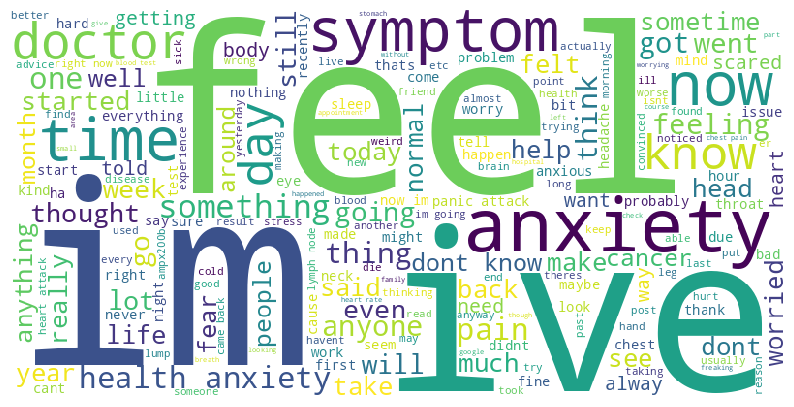

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

words_string = ' '.join(words_list_df['Words'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400,background_color='white').generate(words_string)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='nearest')
plt.axis('off')
plt.show()


In [ ]:
health_anxiety_subreddit_df = indicators_df.filter(col("subreddit") == "healthanxiety").cache()
health_anxiety_subreddit_df = health_anxiety_subreddit_df.withColumn("post", lower(col("post")))


In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="post", outputCol="words1")

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

#  term frequency vectors
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="raw_features")

# IDF model
idf = IDF(inputCol="raw_features", outputCol="features")

preprocessing_pipeline = Pipeline(stages=[tokenizer, remover, vectorizer, idf])


model = preprocessing_pipeline.fit(anxiety_subreddit_df)

processed_data = model.transform(anxiety_subreddit_df)


values below 15 for k did not seem to generate good topics.

In [ ]:
from pyspark.ml.clustering import LDA



# Number of topics
num_topics = 15

#  LDA instance
lda = LDA(k=num_topics, maxIter=10, featuresCol="features")


lda_model = lda.fit(processed_data)


topics = lda_model.describeTopics()
print("The topics described by their top-weighted terms:")
topics.show(truncate=False)




The topics described by their top-weighted terms:
+-----+------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                                 |termWeights                                                                                                                                                                                                                          |
+-----+------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[3, 8990, 7160, 5283, 2352, 3697, 6761, 9321, 

In [ ]:
vocabulary = model.stages[2].vocabulary

def map_term_indices_to_words(term_indices):
    return [vocabulary[index] for index in term_indices]

topics = lda_model.describeTopics(maxTermsPerTopic=10)
topics_rdd = topics.rdd

mapped_topics = topics_rdd\
    .map(lambda row: (row[0], map_term_indices_to_words(row[1]), row[2]))\
    .toDF(["topic", "words", "weights"])

mapped_topics.show(truncate=False)


+-----+---------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|words                                                                            |weights                                                                                                                                                                                                                              |
+-----+---------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[, rotation, stuffs, iron, nails,

In [ ]:
mapped_topics_pandas = mapped_topics.toPandas()

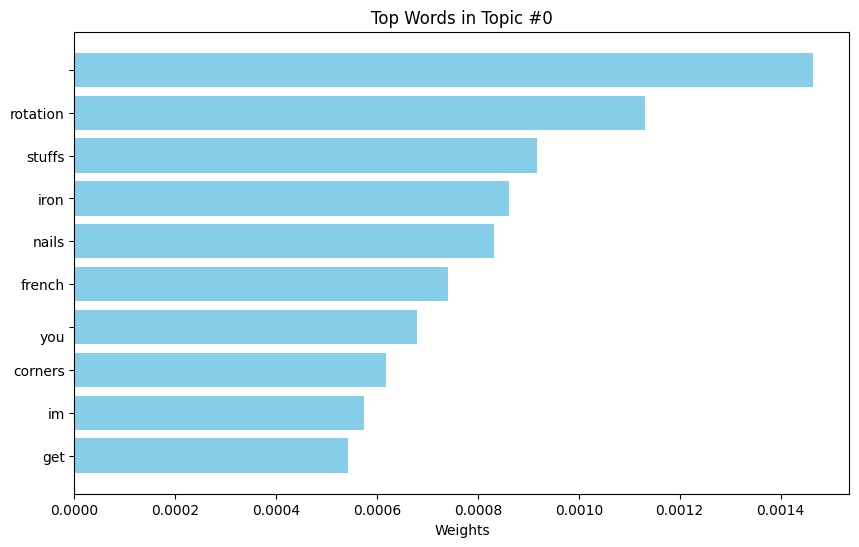

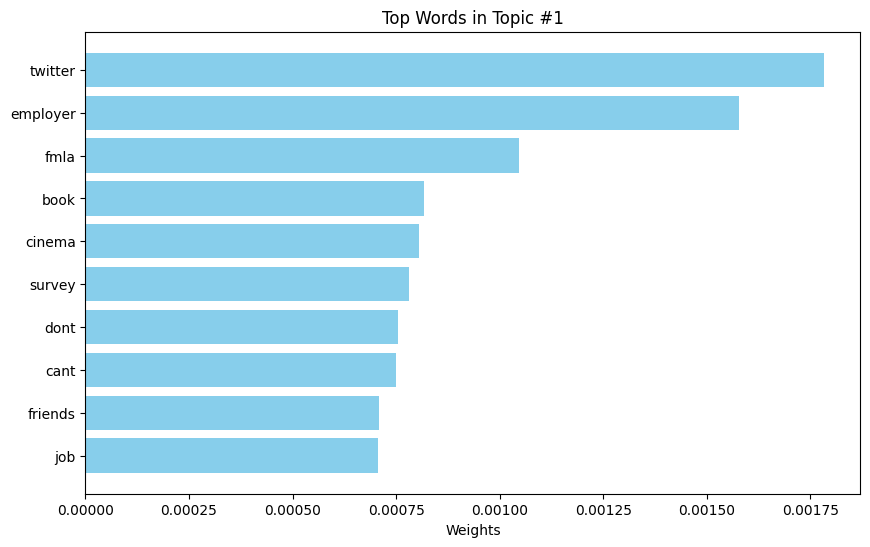

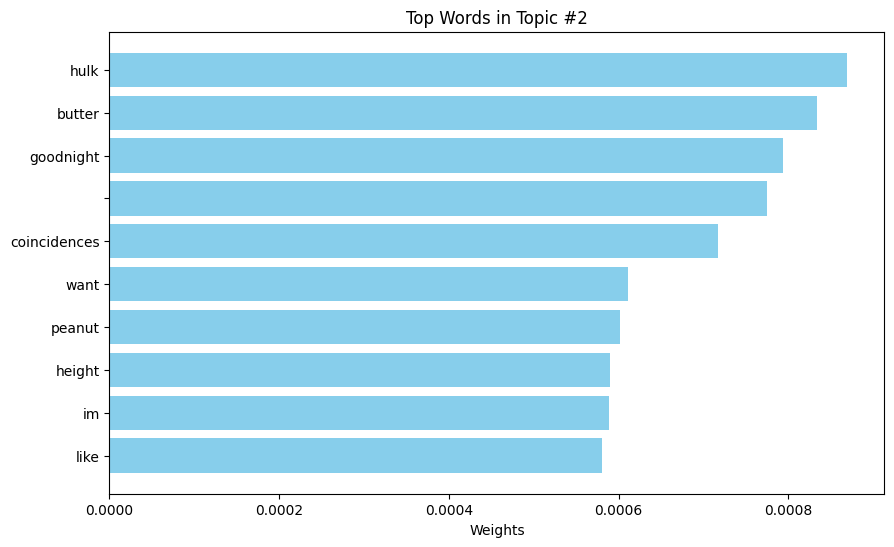

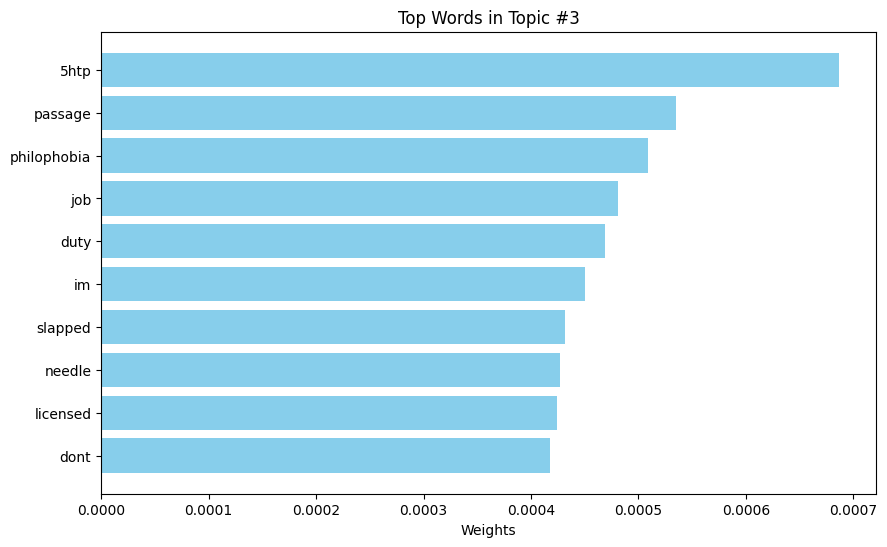

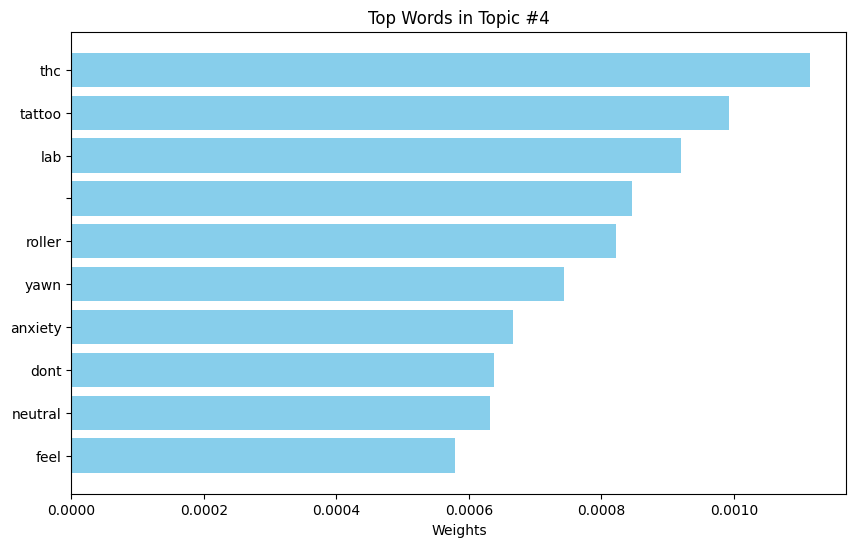

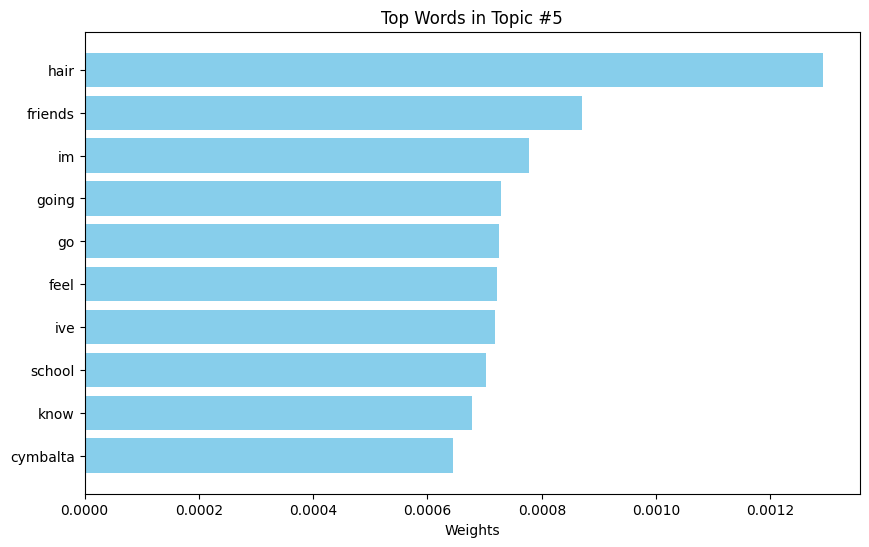

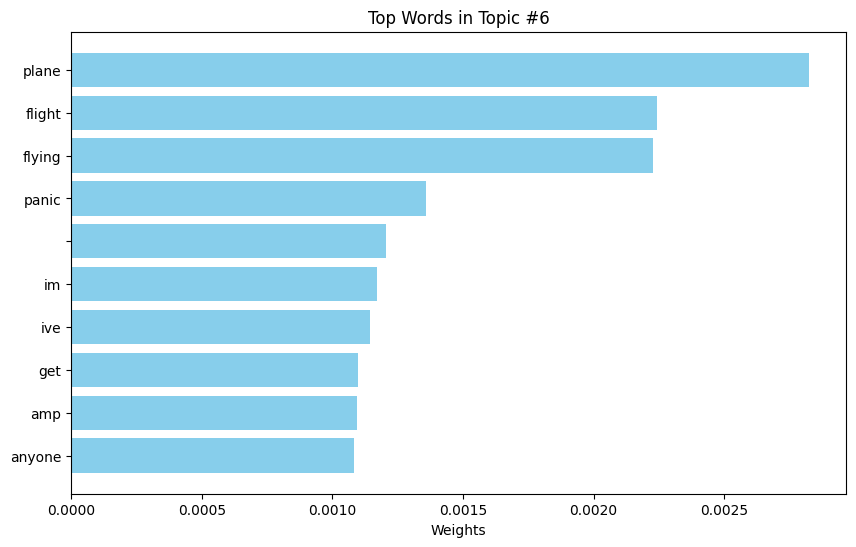

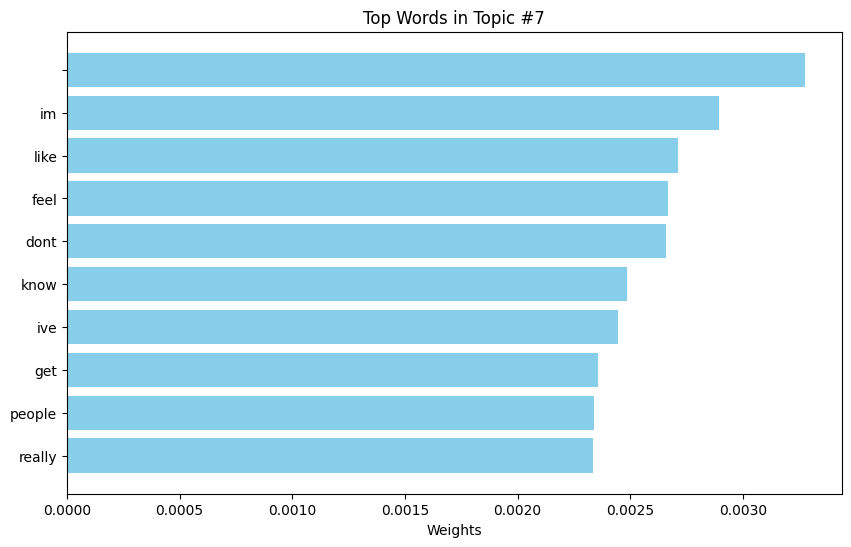

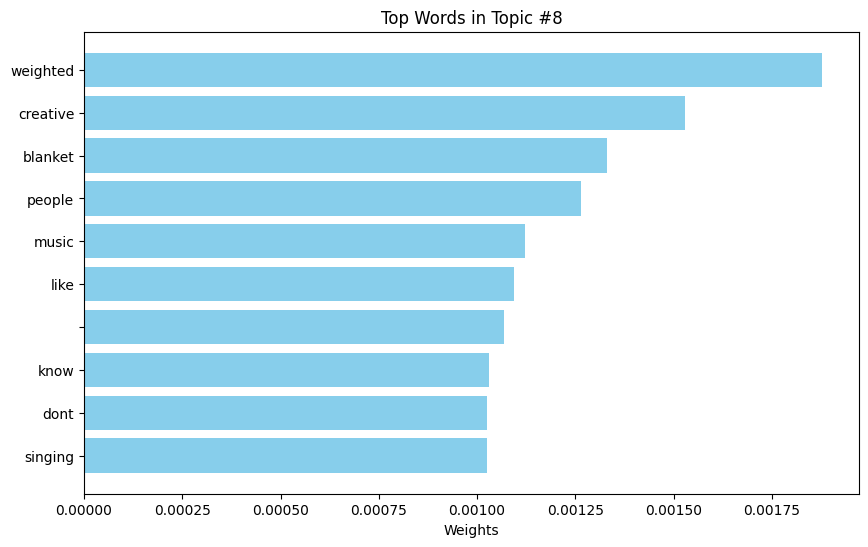

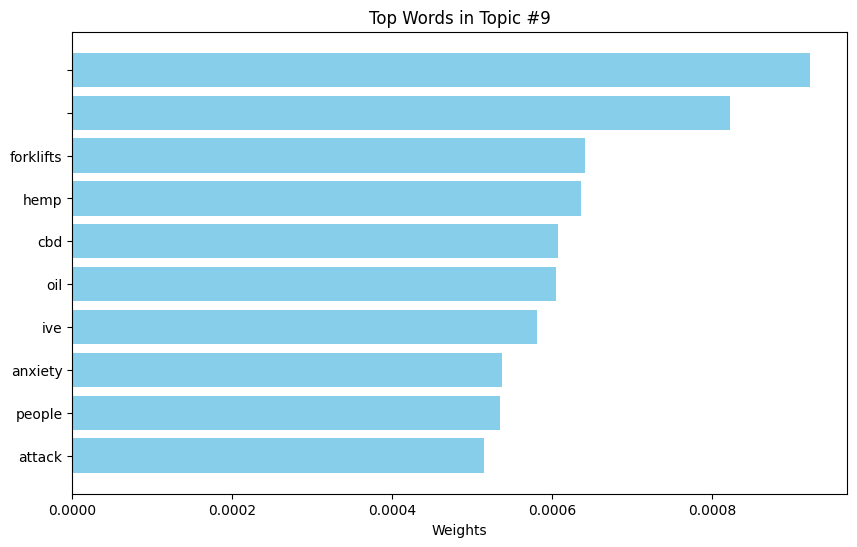

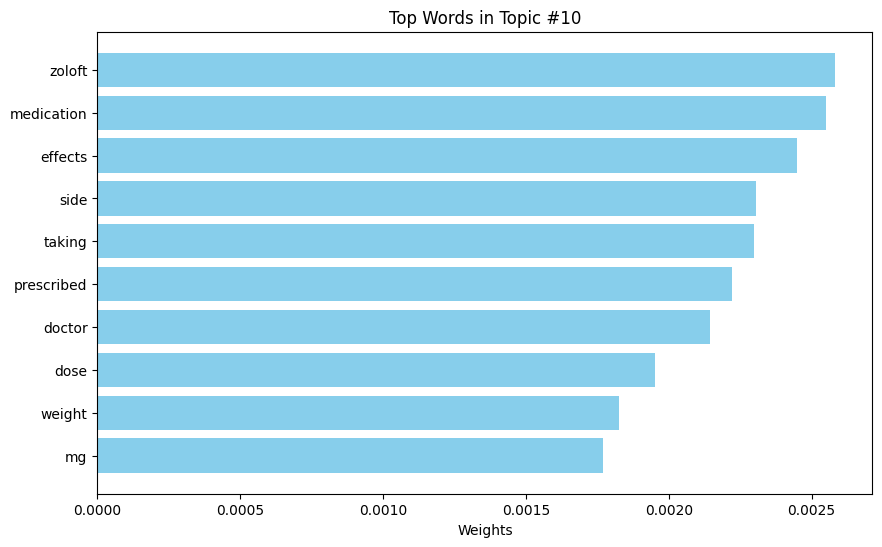

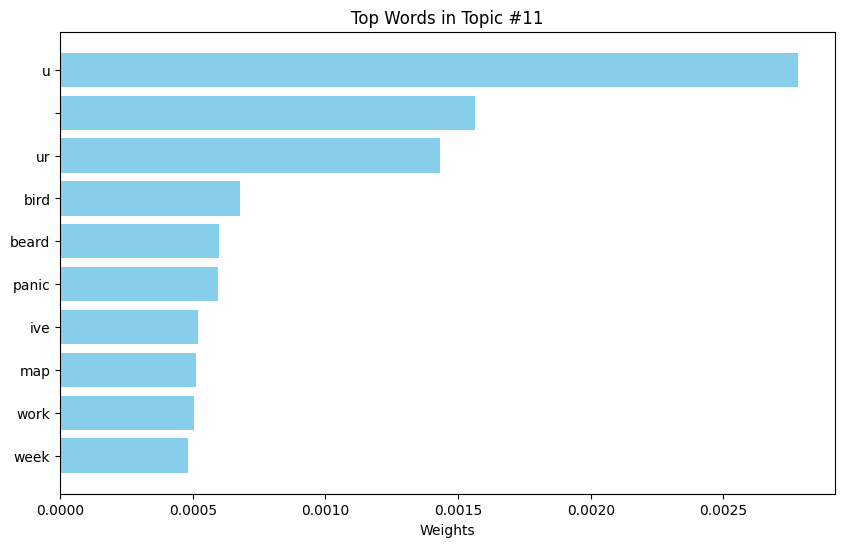

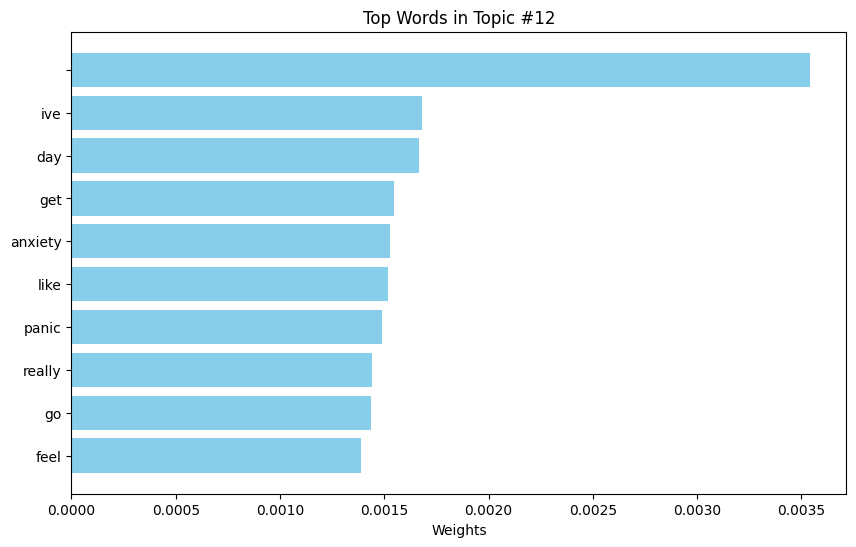

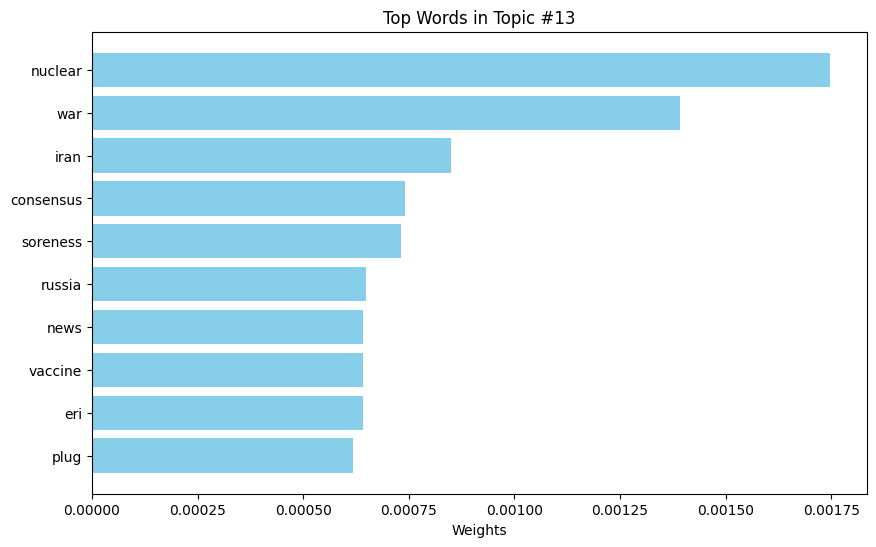

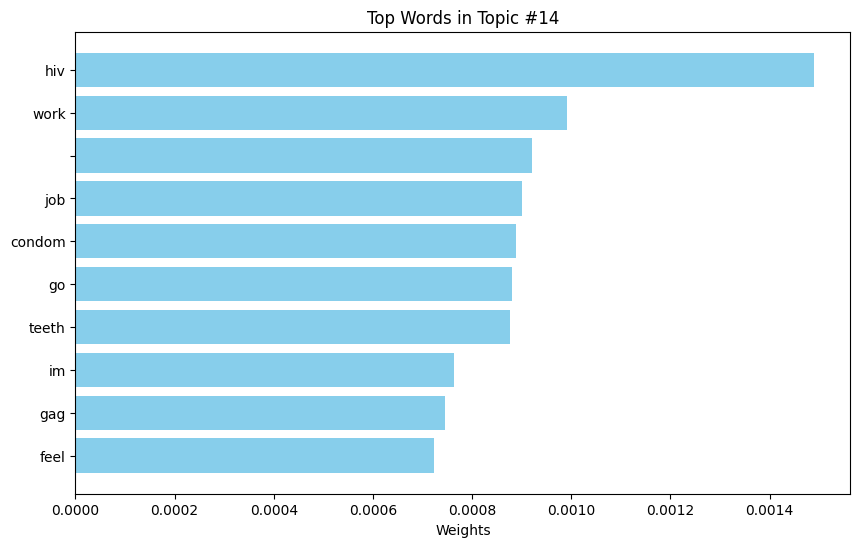

In [ ]:


for index, row in mapped_topics_pandas.iterrows():
    words = row['words']
    weights = row['weights']

    topic_df = pd.DataFrame({'words': words, 'weights': weights})

    topic_df.sort_values('weights', ascending=True, inplace=True)

    plt.figure(figsize=(10, 6))
    plt.barh(topic_df['words'], topic_df['weights'], color='skyblue')
    plt.xlabel('Weights')
    plt.title(f'Top Words in Topic #{index}')
    plt.show()


In [ ]:
from pyspark.ml.feature import Tokenizer, CountVectorizer
from pyspark.ml.clustering import LDA, LDAModel
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("NMFTopicModeling").getOrCreate()

tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsData = tokenizer.transform(posts_df)

cv = CountVectorizer(inputCol="words", outputCol="features", vocabSize=1000, minDF=5)
cvModel = cv.fit(wordsData)
featuresData = cvModel.transform(wordsData)

numTopics = 10
nmf = NMF(k=numTopics, maxIter=100)
nmfModel = nmf.fit(featuresData)

topics = nmfModel.describeTopics(maxTermsPerTopic=10)
topics.show(truncate=False)

# nmfModel.save("nmf_model")

spark.stop()


In [ ]:
#User engagement analysis
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, date_format, count


# Assuming remove_ED_filtered_df is your DataFrame

# Filter posts from Jan 2019 to Dec 2019
filtered_df = remove_ED_filtered_df.filter(
    (year(col("date")) == 2019) &
    (month(col("date")) >= 1) &
    (month(col("date")) <= 12)
)

# Post count per month
posts_per_month = filtered_df.groupBy(date_format(col("date"), "yyyy-MM").alias("month")).count().orderBy("month")

# Post count by author
posts_by_author = filtered_df.groupBy("author").count().orderBy(col("count").desc())

# Convert to Pandas DataFrame for visualization
posts_per_month_pd = posts_per_month.toPandas()
posts_by_author_pd = posts_by_author.toPandas()



In [ ]:
#save to csv
posts_per_month_pd.to_csv("/content/posts_per_month.csv")

In [ ]:
import plotly.express as px
fig = px.bar(posts_per_month_pd, x='month', y='count', title='Post Count per Month in 2019')
fig.show()


In [ ]:
N = 10
fig = px.bar(posts_by_author_pd.head(N), x='author', y='count', title='Top Authors by Post Count in 2019')
fig.show()


In [ ]:
from pyspark.sql.functions import date_format

posts_per_month_subreddit = filtered_df.groupBy(
    "subreddit",
    date_format(col("date"), "yyyy-MM").alias("month")
).count().orderBy("subreddit", "month")

posts_per_month_subreddit_pd = posts_per_month_subreddit.toPandas()

posts_per_month_subreddit_pd.to_csv("/content/posts_per_subreddit.csv")

fig = px.line(posts_per_month_subreddit_pd, x='month', y='count', color='subreddit', title='Post Frequency Over Time by Subreddit')
fig.show()


In [ ]:
posts_by_subreddit = filtered_df.groupBy("subreddit").count().orderBy(col("count").desc())

posts_by_subreddit_pd = posts_by_subreddit.toPandas()

posts_by_subreddit_pd.to_csv("/content/distribution_subreddit.csv")

fig = px.pie(posts_by_subreddit_pd, names='subreddit', values='count', title='Distribution of Posts by Subreddit')
fig.show()


In [ ]:
from pyspark.sql.functions import length

avg_length_subreddit = remove_ED_filtered_df.withColumn("post_length", length(col("post"))) \
                                           .groupBy("subreddit") \
                                           .mean("post_length")

avg_length_subreddit_pd = avg_length_subreddit.toPandas()

fig = px.bar(avg_length_subreddit_pd, x='subreddit', y='avg(post_length)', title='Average Post Length by Subreddit')
fig.show()


In [ ]:
from pyspark.sql.functions import dayofweek, date_format

remove_ED_filtered_df = remove_ED_filtered_df.withColumn("day_of_week", dayofweek(col("date")))

posts_by_day_subreddit = remove_ED_filtered_df.groupBy("subreddit", "day_of_week").count()

posts_by_day_subreddit_pd = posts_by_day_subreddit.toPandas()

posts_by_day_subreddit_pd.to_csv("/content/weekly_posts.csv")

fig = px.bar(posts_by_day_subreddit_pd, x='day_of_week', y='count', color='subreddit', title='Post Count by Day of the Week in Each Subreddit')
fig.show()


In [ ]:
import seaborn as sns


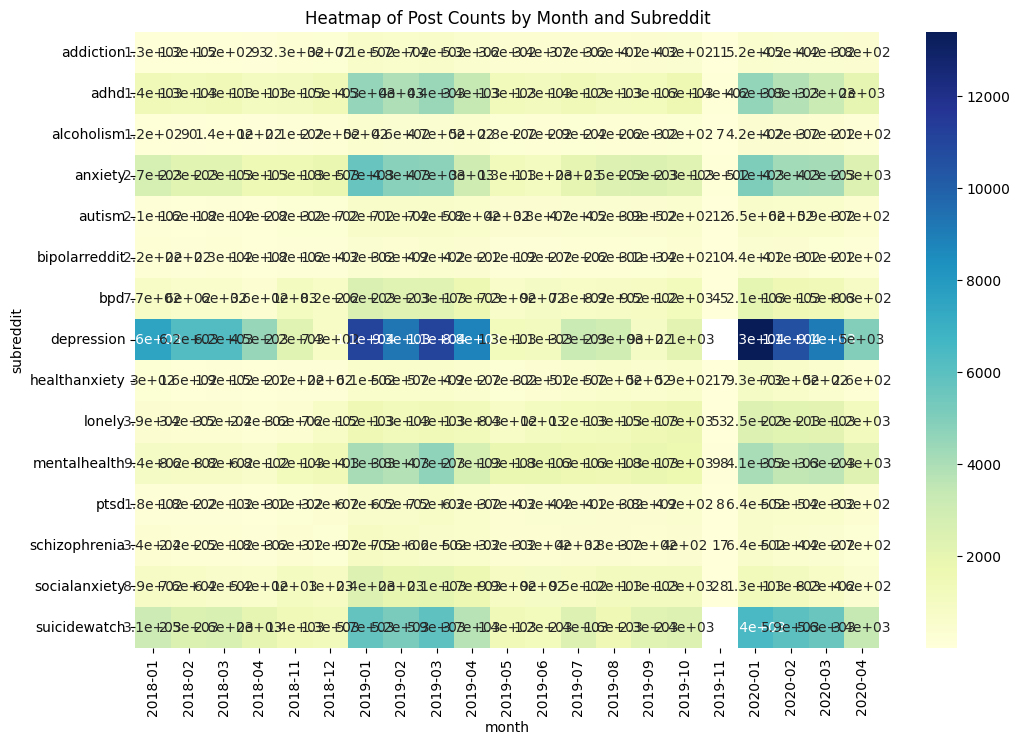

In [ ]:
posts_per_month_subreddit = remove_ED_filtered_df.groupBy("subreddit", date_format(col("date"), "yyyy-MM").alias("month")).count()

heatmap_df = posts_per_month_subreddit.toPandas().pivot(index='subreddit', columns='month', values='count')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, cmap="YlGnBu", annot=True)
plt.title('Heatmap of Post Counts by Month and Subreddit')
plt.show()


In [ ]:
from pyspark.sql.functions import countDistinct

user_cross_subreddit = remove_ED_filtered_df.groupBy("author").agg(countDistinct("subreddit").alias("subreddit_count"))

user_cross_subreddit_pd = user_cross_subreddit.toPandas()

fig = px.histogram(user_cross_subreddit_pd, x='subreddit_count', title='User Participation Across Multiple Subreddits')
fig.show()


In [ ]:
import pandas as pd

# Define the data as a list of dictionaries
data = [
    {"Subreddit": "adhd", "Stigma_Keywords": [
        "hyperactive", "distracted", "unfocused", "scatterbrained", "impulsive", "inattentive",
        "restless", "disorganized", "forgetful", "unproductive", "careless", "undisciplined",
        "disruptive", "uncontrollable", "disorderly", "overactive", "irresponsible", "chaotic", "irrational", "disorder"
    ]},
    {"Subreddit": "autism", "Stigma_Keywords": [
        "autistic", "asperger", "neurodivergent", "rigid", "awkward", "uncommunicative",
        "inflexible", "socially challenged", "withdrawn", "obsessive", "repetitive", "isolated",
        "different", "strange", "eccentric", "odd", "quirky", "weird", "picky", "self-absorbed"
    ]},
    {"Subreddit": "bpd", "Stigma_Keywords": [
        "borderline", "personality", "disorder", "manipulative", "unstable", "dramatic",
        "impulsive", "attention-seeking", "chaotic", "intense", "volatile", "unpredictable",
        "difficult", "emotional", "fragile", "needy", "self-destructive", "reckless",
        "overreactive", "dysfunctional"
    ]},
    {"Subreddit": "addiction", "Stigma_Keywords": [
        "junkie", "addict", "substance abuser", "dependent", "druggie", "crackhead",
        "alcoholic", "stoner", "user", "wasted", "intoxicated", "high", "fiend", "cravings",
        "relapse", "rehab", "dirty", "strung out", "downward spiral", "junkie den"
    ]},
    {"Subreddit": "depression", "Stigma_Keywords": [
        "lazy", "hopeless", "mood killer", "worthless", "sad", "useless", "pathetic",
        "downer", "gloomy", "burden", "fragile", "crybaby", "sufferer", "unmotivated",
        "damaged", "crazy", "broken", "unproductive", "whiner", "loser"
    ]},
    {"Subreddit": "social_anxiety", "Stigma_Keywords": [
        "shy", "awkward", "fearful", "anxious", "nervous wreck", "antisocial", "timid",
        "introverted", "insecure", "withdrawn", "scaredy-cat", "panic-stricken", "self-conscious",
        "paranoid", "freaked out", "frightened", "avoidant", "phobic", "isolated", "pathetic"
    ]},
    {"Subreddit": "bipolarreddit", "Stigma_Keywords": [
        "manic", "depressive", "mood swings", "crazy", "unstable", "insane", "erratic",
        "volatile", "unpredictable", "bipolar", "mentally ill", "psycho", "freak", "nutcase",
        "lunatic", "mad", "whacko", "unhinged", "emotional wreck", "out of control"
    ]},
    {"Subreddit": "ptsd", "Stigma_Keywords": [
        "trauma", "flashbacks", "nightmares", "triggered", "shell-shocked", "damaged", "unstable",
        "unpredictable", "volatile", "irrational", "mentally scarred", "broken", "freak", "crazy",
        "emotional wreck", "unhinged", "fragile", "paranoid", "frightened", "combat fatigue"
    ]},
    {"Subreddit": "alcoholism", "Stigma_Keywords": [
        "drunkard", "alcoholic", "boozer", "wino", "lush", "addict", "inebriated", "sot",
        "binge drinker", "lush", "inebriate", "alcohol-dependent", "wasted", "inebriation",
        "intoxicated", "alcohol abuse", "rehab patient", "problem drinker", "barfly", "groggy"
    ]},
    {"Subreddit": "healthanxiety", "Stigma_Keywords": [
        "hypochondria", "obsessed", "overreactive", "worrier", "paranoid", "irrational",
        "panic-prone", "neurotic", "compulsive", "exaggerator", "anxious", "nervous", "fearful",
        "overthinking", "disease-phobic", "symptom-checker", "doctor-shopper", "catastrophizer",
        "overanalyzer", "anxiety-ridden"
    ]},
    {"Subreddit": "lonely", "Stigma_Keywords": [
        "isolated", "alone", "deserted", "outcast", "rejected", "unwanted", "friendless",
        "unlovable", "miserable", "abandoned", "shut-in", "introverted", "withdrawn", "solitary",
        "pathetic", "loser", "antisocial", "unpopular", "pariah", "desolate"
    ]},
    {"Subreddit": "anxiety", "Stigma_Keywords": [
        "worrywart", "nervous wreck", "panicky", "fearful", "irrational", "obsessive", "neurotic",
        "overreactive", "freaked out", "paranoid", "agitated", "apprehensive", "high-strung",
        "jittery", "restless", "edgy", "tense", "anxious wreck", "panic-stricken", "stressed out"
    ]}
]

df = pd.DataFrame(data)

df.to_csv("stigma_keywords.csv", index=False)



In [ ]:
path_to_stigma_keywords_csv = "/content/stigma_keywords.csv"
stigma_keywords_df = spark.read.csv(path_to_stigma_keywords_csv, header=True)


In [ ]:
stigma_keywords_df.show()

+--------------+--------------------+
|     Subreddit|     Stigma_Keywords|
+--------------+--------------------+
|          adhd|['hyperactive', '...|
|        autism|['autistic', 'asp...|
|           bpd|['borderline', 'p...|
|     addiction|['junkie', 'addic...|
|    depression|['lazy', 'hopeles...|
|social_anxiety|['shy', 'awkward'...|
| bipolarreddit|['manic', 'depres...|
|          ptsd|['trauma', 'flash...|
|    alcoholism|['drunkard', 'alc...|
| healthanxiety|['hypochondria', ...|
|        lonely|['isolated', 'alo...|
|       anxiety|['worrywart', 'ne...|
+--------------+--------------------+



In [ ]:
from pyspark.sql.functions import col, split

# Convert the "Stigma_Keywords" column from string to array of strings
stigma_keywords_df = stigma_keywords_df.withColumn(
    "Stigma_Keywords",
    split(col("Stigma_Keywords"), ",")  # Split the string by comma to create an array
)

stigma_keywords_df.show(truncate=False)


+--------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Subreddit     |Stigma_Keywords                                                                                                                                                                                                                                                                                                           |
+--------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|adh

In [ ]:
from pyspark.sql.functions import col

#desired subreddits
desired_subreddits = ["adhd", "autism", "ptsd", "anxiety", "alcoholism", "bpd", "addiction",
                      "depression", "social_anxiety", "bipolarreddit", "lonely", "health_anxiety"]

#select only the desired subreddits
selected_subreddits_df = remove_ED_filtered_df.filter(col("Subreddit").isin(desired_subreddits))

#resulting DataFrame
selected_subreddits_df.show()


+----------+-------------------+----------+--------------------+----------+
| subreddit|             author|      date|                post|month_year|
+----------+-------------------+----------+--------------------+----------+
|depression|           peeepeed|2020-01-01|My heart aches bu...|   2020-01|
|depression|   cookieexpertuser|2020-01-01|Cheers I’m not su...|   2020-01|
|depression|         Ghostiez23|2020-01-01|Fuck titles. I’m ...|   2020-01|
|depression|           wisqrg50|2020-01-01|suffering from lo...|   2020-01|
|depression|   arizonwatermelon|2020-01-01|I can already tel...|   2020-01|
|depression|ThatBloodyValentine|2020-01-01|I just turned 19 ...|   2020-01|
|depression|     chiefkeith7511|2020-01-01|Is there any way ...|   2020-01|
|depression|        dustin_keel|2020-01-01|Horrid mood swing...|   2020-01|
|depression|         BaIA102037|2020-01-01|ANHEDONIA &amp; e...|   2020-01|
|depression|      bounce-bounce|2020-01-01|Empty I wanted to...|   2020-01|
|depression|

In [ ]:
from pyspark.sql.functions import col, lower

# Tokenize the "post" column
tokenizer = Tokenizer(inputCol="post", outputCol="tokenized_post")
selected_subreddits_df = tokenizer.transform(selected_subreddits_df)




In [ ]:
from pyspark.sql.functions import col, lower,expr

selected_subreddits_df = selected_subreddits_df.withColumn(
    "tokenized_post",
    expr("transform(tokenized_post, token -> lower(token))")
)

selected_subreddits_df.show(truncate=False)


+----------+-------------------+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
selected_subreddits_df = selected_subreddits_df.drop("post_no_punctuation")


In [ ]:
from pyspark.sql.functions import col, array_intersect

selected_columns = ["subreddit", "tokenized_post"]

joined_df = selected_subreddits_df.join(stigma_keywords_df, "subreddit", "inner")

joined_df = joined_df.withColumn("matching_words", array_intersect(col("tokenized_post"), col("Stigma_Keywords")))

joined_df.select(selected_columns + ["matching_words"]).show(truncate=False)


+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.sql import functions as F
import pandas as pd

# Group by subreddit and count the number of matching words
subreddit_counts = joined_df.groupBy("subreddit") \
    .agg(F.sum(F.size("matching_words")).alias("matching_words_count")) \
    .toPandas()

print(subreddit_counts)


DEPRESSION ANALYSIS

In [ ]:
#CHECK
#select only posts from subreddit depression
depression_subreddit_df = indicators_df.filter(col("subreddit") == "depression")
depression_subreddit_df = depression_subreddit_df.withColumn("post", lower(col("post")))
depression_subreddit_df = depression_subreddit_df.withColumn("post", regexp_replace(col("post"), "[^\w\s]", ""))



In [ ]:
depression_subreddit_df.show()

+----------+-------------------+----------+--------------------+----------+
| subreddit|             author|      date|                post|month_year|
+----------+-------------------+----------+--------------------+----------+
|depression|           peeepeed|2020-01-01|my heart aches bu...|   2020-01|
|depression|   cookieexpertuser|2020-01-01|cheers im not sur...|   2020-01|
|depression|         Ghostiez23|2020-01-01|fuck titles im de...|   2020-01|
|depression|           wisqrg50|2020-01-01|suffering from lo...|   2020-01|
|depression|   arizonwatermelon|2020-01-01|i can already tel...|   2020-01|
|depression|ThatBloodyValentine|2020-01-01|i just turned 19 ...|   2020-01|
|depression|     chiefkeith7511|2020-01-01|is there any way ...|   2020-01|
|depression|        dustin_keel|2020-01-01|horrid mood swing...|   2020-01|
|depression|         BaIA102037|2020-01-01|anhedonia amp emo...|   2020-01|
|depression|      bounce-bounce|2020-01-01|empty i wanted to...|   2020-01|
|depression|

In [ ]:
depression_subreddit_df = depression_subreddit_df.withColumn("words", split(col("post"), " "))


In [ ]:
depression_subreddit_df.show()

+----------+-------------------+----------+--------------------+----------+--------------------+
| subreddit|             author|      date|                post|month_year|               words|
+----------+-------------------+----------+--------------------+----------+--------------------+
|depression|           peeepeed|2020-01-01|my heart aches bu...|   2020-01|[my, heart, aches...|
|depression|   cookieexpertuser|2020-01-01|cheers im not sur...|   2020-01|[cheers, im, not,...|
|depression|         Ghostiez23|2020-01-01|fuck titles im de...|   2020-01|[fuck, titles, im...|
|depression|           wisqrg50|2020-01-01|suffering from lo...|   2020-01|[suffering, from,...|
|depression|   arizonwatermelon|2020-01-01|i can already tel...|   2020-01|[i, can, already,...|
|depression|ThatBloodyValentine|2020-01-01|i just turned 19 ...|   2020-01|[i, just, turned,...|
|depression|     chiefkeith7511|2020-01-01|is there any way ...|   2020-01|[is, there, any, ...|
|depression|        dustin_kee

In [ ]:
depression_exploded_df = depression_subreddit_df.withColumn("word", explode(col("words"))).cache()

In [ ]:
depression_exploded_df.show()

+----------+--------+----------+--------------------+----------+--------------------+------------+
| subreddit|  author|      date|                post|month_year|               words|        word|
+----------+--------+----------+--------------------+----------+--------------------+------------+
|depression|peeepeed|2020-01-01|my heart aches bu...|   2020-01|[my, heart, aches...|          my|
|depression|peeepeed|2020-01-01|my heart aches bu...|   2020-01|[my, heart, aches...|       heart|
|depression|peeepeed|2020-01-01|my heart aches bu...|   2020-01|[my, heart, aches...|       aches|
|depression|peeepeed|2020-01-01|my heart aches bu...|   2020-01|[my, heart, aches...|         but|
|depression|peeepeed|2020-01-01|my heart aches bu...|   2020-01|[my, heart, aches...|           i|
|depression|peeepeed|2020-01-01|my heart aches bu...|   2020-01|[my, heart, aches...|        cant|
|depression|peeepeed|2020-01-01|my heart aches bu...|   2020-01|[my, heart, aches...|       break|
|depressio

In [ ]:
#depression_subreddit_df = depression_subreddit_df.selectExpr("*", "explode(words) as word")


In [ ]:
depression_subreddit_df.show()

+----------+-------------------+----------+--------------------+----------+--------------------+
| subreddit|             author|      date|                post|month_year|               words|
+----------+-------------------+----------+--------------------+----------+--------------------+
|depression|           peeepeed|2020-01-01|my heart aches bu...|   2020-01|[my, heart, aches...|
|depression|   cookieexpertuser|2020-01-01|cheers im not sur...|   2020-01|[cheers, im, not,...|
|depression|         Ghostiez23|2020-01-01|fuck titles im de...|   2020-01|[fuck, titles, im...|
|depression|           wisqrg50|2020-01-01|suffering from lo...|   2020-01|[suffering, from,...|
|depression|   arizonwatermelon|2020-01-01|i can already tel...|   2020-01|[i, can, already,...|
|depression|ThatBloodyValentine|2020-01-01|i just turned 19 ...|   2020-01|[i, just, turned,...|
|depression|     chiefkeith7511|2020-01-01|is there any way ...|   2020-01|[is, there, any, ...|
|depression|        dustin_kee

In [ ]:
stigma_keywords = [
    "lazy", "hopeless", "downer", "worthless", "useless", "pathetic", "gloomy",
    "burden", "fragile", "crybaby", "sufferer", "unmotivated", "damaged", "crazy",
    "broken", "unproductive", "whiner", "loser"
]

In [ ]:
from pyspark.sql.functions import array_contains


In [ ]:
depression_exploded_df = depression_exploded_df.where(col("word").isin(stigma_keywords))


In [ ]:
word_count_df = depression_exploded_df.groupBy("word").count()


In [ ]:
word_count_df = depression_exploded_df.groupBy("word").agg(count("word").alias("counts"))


In [ ]:
word_count_df_pandas = word_count_df.toPandas()


In [ ]:
fig = px.bar(word_count_df_pandas, x='word', y='counts', title='Count of Stigma keywords appearing in the subreddit Depression')
fig.update_traces(marker_color='darkseagreen')

fig.show()

In [ ]:

hopeless_count = depression_subreddit_df.filter(col("post").contains("worthless")).count()

total_posts = depression_subreddit_df.count()

percentage_hopeless_posts = (hopeless_count / total_posts) * 100

print(f"Number of posts containing 'hopeless': {hopeless_count}")
print(f"Percentage of posts containing 'hopeless': {percentage_hopeless_posts:.2f}%")



Number of posts containing 'hopeless': 3799
Percentage of posts containing 'hopeless': 3.24%


In [ ]:
help_count = suicide_subreddit_df.filter(col("post").contains("help")).count()

total_posts = suicide_subreddit_df.count()

percentage_help_posts = (help_count / total_posts) * 100

print(f"Number of posts containing 'help': {help_count}")
print(f"Percentage of posts containing 'help': {percentage_help_posts:.2f}%")


Number of posts containing 'help': 33650
Percentage of posts containing 'help': 65.84%


In [ ]:
from pyspark.sql.functions import length

avg_length_subreddit = remove_ED_filtered_df.withColumn("post_length", length(col("post"))) \
                                           .groupBy("subreddit") \
                                           .mean("post_length")

avg_length_subreddit_pd = avg_length_subreddit.toPandas()




In [ ]:
# Plot
fig = px.bar(avg_length_subreddit_pd, x='subreddit', y='avg(post_length)', title='Average Post Length by Subreddit')
fig.update_traces(marker_color='palegreen')

fig.show()

In [ ]:
subreddit_counts_df.head()

,subreddit,count
0,depression,117331
1,suicidewatch,66161
2,anxiety,57671
3,adhd,45631
4,mentalhealth,45332


In [ ]:
total_count = subreddit_counts_df['count'].sum()
subreddit_counts_df['percentage'] = (subreddit_counts_df['count'] / total_count) * 100


In [ ]:
import plotly.express as px

fig = px.pie(
    subreddit_counts_df,
    names='subreddit',
    values='percentage',
    title='Post Percentage per subreddit',
    color_discrete_sequence=px.colors.sequential.Greens_r  # Set the color to Greens
)

fig.show()


In [ ]:
'''word_count_df = suicide_subreddit_df.groupBy("word").agg(count("word").alias("counts"))
word_count_df_pandas = word_count_df.toPandas()
fig = px.bar(word_count_df_pandas, x='word', y='counts', title='Word Count in Suicidewatch Subreddit Posts')
fig.show()
'''


In [ ]:

'''
suicidal_indicators = ["help", "done", "cant do this anymore", "end it", "no point", "tired", "worthless", "hopeless", "give up", "not want to live"]
# Tokenize the 'post' column into words
suicide_subreddit_df = suicide_subreddit_df.withColumn("words", split(col("post"), " "))


suicide_subreddit_df = suicide_subreddit_df.withColumn("word", explode(col("words")))


suicide_subreddit_df = suicide_subreddit_df.where(col("word").isin(suicidal_indicators))

word_count_df = suicide_subreddit_df.groupBy("word").count()

word_count_df.show()'''

In [ ]:
suicide_posts_df = selected_df.filter(selected_df["subreddit"] == "suicidewatch")


In [ ]:
suicide_posts_df_pandas = suicide_posts_df.toPandas()

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import col, lower, regexp_replace, explode, array_contains

In [ ]:
suicide_posts_df = suicide_posts_df.withColumn("post", lower(col("post")))
suicide_posts_df = suicide_posts_df.withColumn("post", regexp_replace(col("post"), "[^a-zA-Z\\s]", ""))

In [ ]:
# Tokenization
tokenizer = Tokenizer(inputCol="post", outputCol="words")
suicide_posts_df = tokenizer.transform(suicide_posts_df)

In [ ]:

default_stopwords = StopWordsRemover.loadDefaultStopWords("english")

In [ ]:
custom_stopwords = [
    "im","ive", "you","we", "they", "he", "she", "it’s", "dont", "cant", "didnt", "wont", "isnt", "arent",
    "get", "know", "want", "like", "feel", "have", "be", "do", "did", "does", "doing", "am", "are", "is", "been", "being",
    "really", "just", "so", "well", "very", "too", "much", "such", "thing", "things", "lot", "kind", "sort", "type", "bit",
    "actually", "basically", "probably", "possibly", "literally", "everybody", "nobody", "someone",
    "everything", "nothing", "anything", "whatever", "whenever", "wherever", "however","","=","think","even","something","kill","today","thought",
    "going","go","said","still","life","one","told","alway","feels","always","never","time",
]

In [ ]:
all_stopwords = default_stopwords + custom_stopwords
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=all_stopwords)
suicide_posts_df = stopwords_remover.transform(suicide_posts_df)

In [ ]:

# Filter to include only rows containing 'help'
help_df = suicide_posts_df.filter(array_contains(col("filtered_words"), "help"))


In [ ]:
word_frequencies = help_df.withColumn("word", explode(col("filtered_words")))
word_frequencies = word_frequencies.filter(word_frequencies.word != "help")
word_frequencies = word_frequencies.groupBy("word").count().orderBy("count", ascending=False)

word_frequencies.show()


+-------+-----+
|   word|count|
+-------+-----+
| people|13253|
|friends| 8793|
|  years| 8602|
|   need| 7408|
|anymore| 7407|
|    day| 7127|
| family| 7070|
|suicide| 6902|
|    way| 6683|
|   make| 6534|
|    got| 6317|
|   back| 6287|
| better| 6245|
|    end| 6098|
|    die| 6058|
|   live| 5965|
|    see| 5964|
|   good| 5925|
| school| 5861|
|  every| 5853|
+-------+-----+
only showing top 20 rows



In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank

In [ ]:

window_spec = Window.orderBy(word_frequencies['count'].desc())
sorted_word_frequencies = word_frequencies.withColumn('rank', rank().over(window_spec))

# Select the top 20 and bottom 20 words
top_words = sorted_word_frequencies.filter(sorted_word_frequencies['rank'] <= 20)
bottom_words = sorted_word_frequencies.filter(sorted_word_frequencies['rank'] > (sorted_word_frequencies.count() - 20))


top_words_pd = top_words.toPandas()


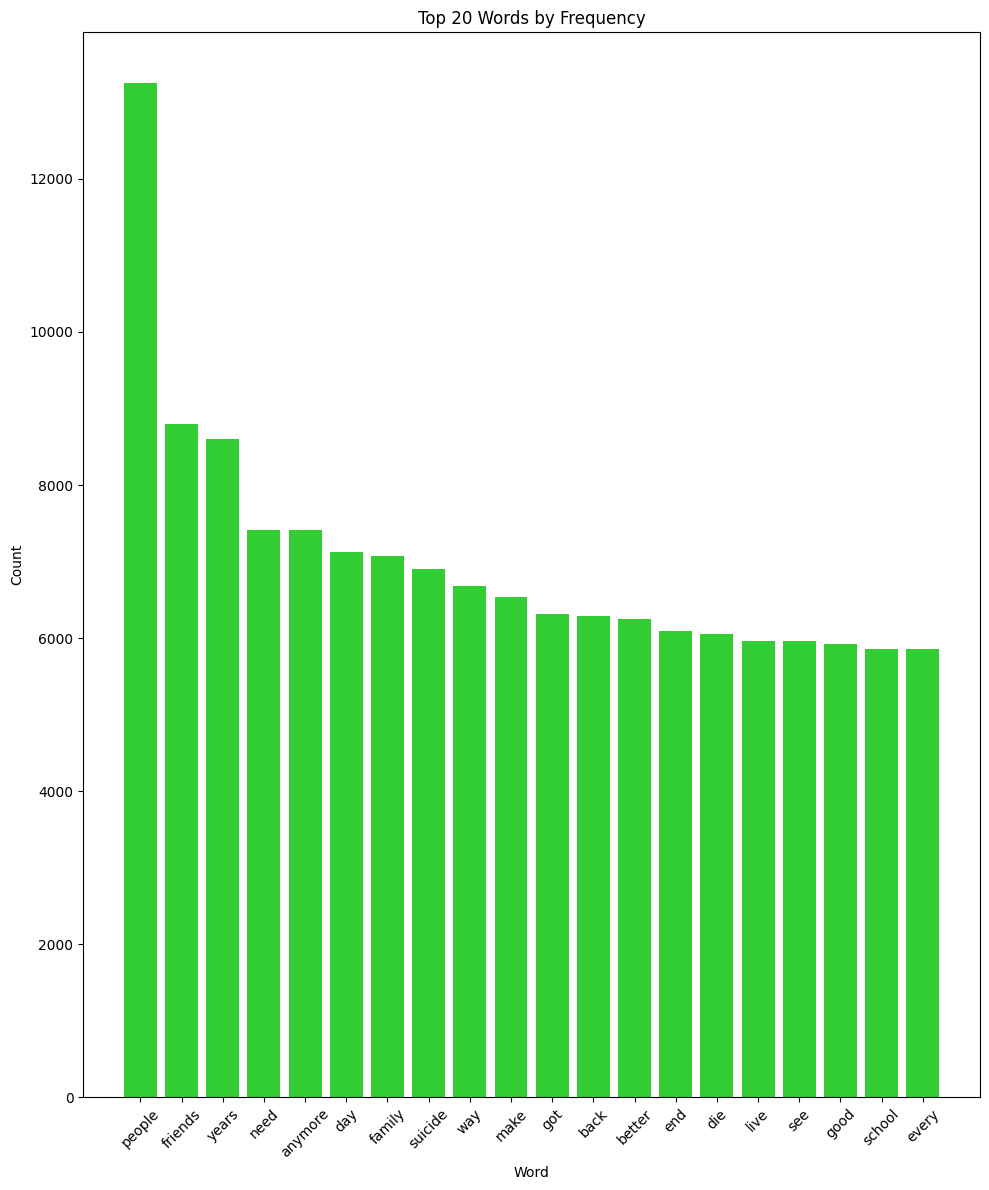

In [ ]:

import matplotlib.pyplot as plt

fig, (ax1) = plt.subplots(1, figsize=(10, 12))

# Plot the top 20 words
ax1.bar(top_words_pd['word'], top_words_pd['count'], color='limegreen')
ax1.set_xlabel('Word')
ax1.set_ylabel('Count')
ax1.set_title('Top 20 Words by Frequency')
ax1.tick_params(axis='x', rotation=45)




plt.tight_layout()


plt.show()
